In [22]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.5 GB  | Proc size: 502.1 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [23]:
# importing necessary libraries
import re
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import pandas as pd
import random as rn
import seaborn as sns
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt  
from urllib.parse import urlparse
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import concatenate, GRU, Input, Embedding, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling1D

In [24]:
import warnings
K.set_floatx('float64')
warnings.filterwarnings('ignore')

In [25]:
np.random.seed(12)
tf.random.set_seed(13)
rn.seed(14)

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
#clean data
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', '\xa0', '\t',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '\u3000', '\u202f',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

mispell_dict = {"aren't" : "are not", "can't" : "cannot", "couldn't" : "could not", "couldnt" : "could not", "didn't" : "did not", "doesn't" : "does not",
                "doesnt" : "does not", "don't" : "do not", "hadn't" : "had not", "hasn't" : "has not", "haven't" : "have not", "havent" : "have not",
                "he'd" : "he would", "he'll" : "he will", "he's" : "he is", "i'd" : "I would", "i'd" : "I had", "i'll" : "I will", "i'm" : "I am",
                "isn't" : "is not","it's" : "it is","it'll":"it will", "i've" : "I have", "let's" : "let us", "mightn't" : "might not", "mustn't" : "must not",
                "shan't" : "shall not", "she'd" : "she would", "she'll" : "she will", "she's" : "she is", "shouldn't" : "should not", "shouldnt" : "should not",
                "that's" : "that is", "thats" : "that is", "there's" : "there is", "theres" : "there is", "they'd" : "they would", "they'll" : "they will",
                "they're" : "they are", "theyre":  "they are", "they've" : "they have", "we'd" : "we would", "we're" : "we are", "weren't" : "were not",
                "we've" : "we have", "what'll" : "what will", "what're" : "what are", "what's" : "what is", "what've" : "what have", "where's" : "where is",
                "who'd" : "who would", "who'll" : "who will", "who're" : "who are", "who's" : "who is", "who've" : "who have", "won't" : "will not",
                "wouldn't" : "would not", "you'd" : "you would", "you'll" : "you will", "you're" : "you are", "you've" : "you have", "'re": " are",
                "wasn't": "was not", "we'll":" will", "didn't": "did not", "tryin'":"trying"}

def clean_text(x):
    x = str(x).replace("\n","")
    for punct in puncts:
        x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    x = re.sub('[0-9]{5,}', '#####', x)
    x = re.sub('[0-9]{4}', '####', x)
    x = re.sub('[0-9]{3}', '###', x)
    x = re.sub('[0-9]{2}', '##', x)
    return x

def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

def replace_typical_misspell(text):
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

def clean_data(df, columns):
    for col in tqdm(columns):
        df[col] = df[col].apply(lambda x: re.sub(' +', ' ', x)).values
        df[col] = df[col].apply(lambda x: re.sub('\n', '', x)).values
        df[col] = df[col].apply(lambda x: clean_numbers(x)).values
        df[col] = df[col].apply(lambda x: replace_typical_misspell(x)).values
        df[col] = df[col].apply(lambda x: clean_text(x.lower())).values
        df[col] = df[col].apply(lambda x: x.lower()).values
        df[col] = df[col].apply(lambda x: re.sub(' +', ' ', x)).values

    return df

In [28]:
def fix_upvotes(x):
  try:
    return int(x.split('.')[0])
  except:
    return 0

In [29]:
from sklearn.preprocessing import MinMaxScaler
def preprocess_data(train, test, new_features_train, new_features_test, flag=0):

  y = train[train.columns[11:]] # storing the target labels in 'y'

  # I'll be cleaning and adding the domain name from the website's url.
  find = re.compile(r"^[^.]*")
  train['clean_url'] = train['url'].apply(lambda x: re.findall(find, urlparse(x).netloc)[0])
  test['clean_url'] = test['url'].apply(lambda x: re.findall(find, urlparse(x).netloc)[0])

  # creating train and test data
  X = train[['question_title', 'question_body', 'answer', 'clean_url', 'category']]
  X = pd.concat([X, new_features_train], axis=1)
  X_test = test[['question_title', 'question_body', 'answer', 'clean_url', 'category']]
  X_test = pd.concat([X_test, new_features_test], axis=1)
  text_features = ['question_title', 'question_body', 'answer', 'comments_0', 'answer_1', 
                   'comment_1', 'answer_2','comment_2', 'answer_3', 'comment_3']
  num_features = ['upvotes', 'reputation_q', 'gold_q', 'silver_q', 'bronze_q', 
                  'reputation_a', 'gold_a', 'silver_a', 'bronze_a']

  # Cleaning data for contracted words, numbers and punctuations.
  X = clean_data(X, text_features)
  X_test = clean_data(X_test, text_features)

  # splitting the data into train and cv sets.
  X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.1, random_state=42)

  if flag==1:
    return X_train, X_cv, y_train.values, y_cv.values

  # I'll be using these features as categorical OHE features.
  features = ['clean_url', 'category']
  # creating categorical features for train, cv and test data.
  ohe = OneHotEncoder()
  ohe.fit(X_train[features])
  categorical_features_train = ohe.transform(X_train[features]).todense()
  categorical_features_cv = ohe.transform(X_cv[features]).todense()
  categorical_features_test = ohe.transform(X_test[features]).todense()


  # I'll also be using the following scraped numerical features.
  min_max_scaler = MinMaxScaler()
  num_features = ['upvotes', 'reputation_q', 'gold_q', 'silver_q', 'bronze_q', 
                  'reputation_a', 'gold_a', 'silver_a', 'bronze_a']
  numerical_features_train = min_max_scaler.fit_transform(X_train[num_features].values)
  numerical_features_cv = min_max_scaler.transform(X_cv[num_features].values)
  numerical_features_test = min_max_scaler.transform(X_test[num_features].values)

  print('created categorical features, now loading glove vocab...')  

  # I'm henerating a dictionary 'embeddings_index' that holds all the words in the glove.6b as keys and their 300 dimensional embeddings as values.
  embeddings_index = dict()
  oov_vector = np.zeros(300)
  f = open('glove.6B.300d.txt')
  for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    oov_vector += coefs
  f.close()
  print('Loaded %s word vectors.' % len(embeddings_index))
  print('tokenizing the sentences of input data..')

  oov_vector = oov_vector/len(embeddings_index)

###########################################################
  # generating tokens for 'question_title'
  tokenizer = Tokenizer(num_words=None, filters='', lower=True, split=' ', char_level=False, oov_token='oov_word', document_count=0)
  tokenizer.fit_on_texts(X_train['question_title'].values)

  train_title = tokenizer.texts_to_sequences(X_train['question_title'].values)
  cv_title = tokenizer.texts_to_sequences(X_cv['question_title'].values)
  test_title = tokenizer.texts_to_sequences(X_test['question_title'].values)

  # padding the 'question_title' sequences and truncating the sentences of length is > max_length defined above.
  train_title = pad_sequences(train_title, maxlen=max_length_title, padding='post', value=0)
  cv_title = pad_sequences(cv_title, maxlen=max_length_title, padding='post', value=0)
  test_title = pad_sequences(test_title, maxlen=max_length_title, padding='post', value=0)

  # creating embedding_matrix that holds the words in 'question_title' as keys and their respective 300d embeddings as values.
  # I'll use this embedding_matrix in the embedding layer of my model.
  title_vocab_size = len(tokenizer.word_index) + 1
  embedding_matrix_title = np.zeros((title_vocab_size, 300))
  for word, i in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix_title[i] = embedding_vector
    else:
      embedding_matrix_title[i] = oov_vector
  print('created embedding matrix for question_title...')

#############
  # generating tokens for 'question_body'
  tokenizer = Tokenizer(num_words=None, filters='', lower=True, split=' ', char_level=False, oov_token='oov_word', document_count=0)
  tokenizer.fit_on_texts(X_train['question_body'].values)

  train_body = tokenizer.texts_to_sequences(X_train['question_body'].values)
  cv_body = tokenizer.texts_to_sequences(X_cv['question_body'].values)
  test_body = tokenizer.texts_to_sequences(X_test['question_body'].values)

  # padding the 'question_body' sequences and truncating the sentences of length is > max_length defined above.
  train_body = pad_sequences(train_body, maxlen=max_length_body, padding='post', value=0)
  cv_body = pad_sequences(cv_body, maxlen=max_length_body, padding='post', value=0)
  test_body = pad_sequences(test_body, maxlen=max_length_body, padding='post', value=0)

  # creating embedding_matrix that holds the words in 'question_body' as keys and their respective 300d embeddings as values.
  # I'll use this embedding_matrix in the embedding layer of my model.
  body_vocab_size = len(tokenizer.word_index) + 1
  embedding_matrix_body = np.zeros((body_vocab_size, 300))
  for word, i in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix_body[i] = embedding_vector
    else:
      embedding_matrix_body[i] = oov_vector
  print('created embedding matrix for question_body...')

##############
  # generating tokens for 'answer + comments_0'
  tokenizer = Tokenizer(num_words=None, filters='', lower=True, split=' ', char_level=False, oov_token='oov_word', document_count=0)
  tokenizer.fit_on_texts(X_train['answer'].values)

  train_answer = tokenizer.texts_to_sequences(X_train['answer'].values)
  cv_answer = tokenizer.texts_to_sequences(X_cv['answer'].values)
  test_answer = tokenizer.texts_to_sequences(X_test['answer'].values)

  # padding the 'answer' sequences and truncating the sentences of length is > max_length defined above.
  train_answer = pad_sequences(train_answer, maxlen=max_length_answer, padding='post', value=0)
  cv_answer = pad_sequences(cv_answer, maxlen=max_length_answer, padding='post', value=0)
  test_answer = pad_sequences(test_answer, maxlen=max_length_answer, padding='post', value=0)

  # creating embedding_matrix that holds the words in 'answer' as keys and their respective 300d embeddings as values.
  # I'll use this embedding_matrix in the embedding layer of my model.
  answer_vocab_size = len(tokenizer.word_index) + 1
  embedding_matrix_answer = np.zeros((answer_vocab_size, 300))
  for word, i in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix_answer[i] = embedding_vector
    else:
      embedding_matrix_answer[i] = oov_vector
  print('created embedding matrix for answer...')

#####################################################################

 # generating tokens for 'answer_1 + comments_1 + answer_2 + comments_2 + answer_3 + comments_3'
  tokenizer = Tokenizer(num_words=None, filters='', lower=True, split=' ', char_level=False, oov_token='oov_word', document_count=0)
  tokenizer.fit_on_texts((X_train['comments_0'] +' '+ X_train['answer_1'] +' '+ X_train['comment_1'] + ' '+\
                          X_train['answer_2'] +' '+ X_train['comment_2'] + ' '+ X_train['answer_3'] +' '+\
                          X_train['comment_3']).values)

  train_scraped = tokenizer.texts_to_sequences((X_train['comments_0'] +' '+ X_train['answer_1'] +' '+ X_train['comment_1'] + ' '+\
                          X_train['answer_2'] +' '+ X_train['comment_2'] + ' '+ X_train['answer_3'] +' '+\
                          X_train['comment_3']).values)
  
  cv_scraped = tokenizer.texts_to_sequences((X_cv['comments_0'] +' '+ X_cv['answer_1'] +' '+ X_cv['comment_1'] + ' '+\
                          X_cv['answer_2'] +' '+ X_cv['comment_2'] + ' '+ X_cv['answer_3'] +' '+\
                          X_cv['comment_3']).values)
  
  test_scraped = tokenizer.texts_to_sequences((X_test['comments_0'] +' '+ X_test['answer_1'] +' '+ X_test['comment_1'] + ' '+\
                          X_test['answer_2'] +' '+ X_test['comment_2'] + ' '+ X_test['answer_3'] +' '+\
                          X_test['comment_3']).values)
  
  # padding the 'answer' sequences and truncating the sentences of length is > max_length defined above.
  train_scraped = pad_sequences(train_scraped, maxlen=max_length_scraped, padding='post', value=0)
  cv_scraped = pad_sequences(cv_scraped, maxlen=max_length_scraped, padding='post', value=0)
  test_scraped = pad_sequences(test_scraped, maxlen=max_length_scraped, padding='post', value=0)

  # creating embedding_matrix that holds the words in 'answer' as keys and their respective 300d embeddings as values.
  # I'll use this embedding_matrix in the embedding layer of my model.
  scraped_vocab_size = len(tokenizer.word_index) + 1
  embedding_matrix_scraped = np.zeros((scraped_vocab_size, 300))
  for word, i in tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix_scraped[i] = embedding_vector
    else:
      embedding_matrix_scraped[i] = oov_vector
  print('created embedding matrix for answer...')

################################################################################

  # Preparing data for tfidf features by concatenating 'question_title', 'question_body', 'answer' and scraped features.
  text_train = []
  text_cv = []
  text_test = []
  for row in X_train[text_features].values:
    text_train.append(' '.join(row))
  for row in X_cv[text_features].values:
    text_cv.append(' '.join(row))
  for row in X_test[text_features].values:
    text_test.append(' '.join(row))
  
  print('prepared data for tfidf now generating tfidf features...')

  tfidf = TfidfVectorizer(ngram_range=(2,5), max_features=max_features_tfidf)
  train_tfidf = tfidf.fit_transform(text_train)
  cv_tfidf = tfidf.transform(text_cv)
  test_tfidf = tfidf.transform(text_test)
  print('data preprocessing completed!')
  
  return train_title, train_body, train_answer, train_scraped, categorical_features_train, train_tfidf.toarray(), cv_title, cv_body, cv_answer, cv_scraped, categorical_features_cv, cv_tfidf.toarray(), test_title, test_body, test_answer, test_scraped, categorical_features_test, test_tfidf.toarray(), y_train.values, y_cv.values, title_vocab_size, body_vocab_size, answer_vocab_size, scraped_vocab_size, embedding_matrix_title, embedding_matrix_body, embedding_matrix_answer, embedding_matrix_scraped, numerical_features_train, numerical_features_cv, numerical_features_test

In [30]:
def collect_data_for_model(train, test, new_features_train, new_features_test):
  train_title, train_body, train_answer, train_scraped, categorical_features_train, train_tfidf, cv_title, cv_body, cv_answer, cv_scraped, categorical_features_cv, cv_tfidf, test_title, test_body, test_answer, test_scraped, categorical_features_test, test_tfidf, y_train, y_cv, title_vocab_size, body_vocab_size, answer_vocab_size, scraped_vocab_size, embedding_matrix_title, embedding_matrix_body, embedding_matrix_answer, embedding_matrix_scraped, numerical_features_train, numerical_features_cv, numerical_features_test = preprocess_data(train, test, new_features_train, new_features_test)

  input_data = {'title': train_title, 'body': train_body, 'answer': train_answer, 
              'category_input': categorical_features_train, 'tfidf_input': train_tfidf,
              'scraped_input': train_scraped, 'numerical_input': numerical_features_train}

  cv_data = {'title': cv_title, 'body': cv_body, 'answer': cv_answer, 
            'category_input': categorical_features_cv, 'tfidf_input': cv_tfidf,
             'scraped_input': cv_scraped, 'numerical_input': numerical_features_cv}

  test_data = {'title': test_title, 'body': test_body, 'answer': test_answer, 
           'category_input': categorical_features_test, 'tfidf_input': test_tfidf,
           'scraped_input': test_scraped, 'numerical_input': numerical_features_test}

  return input_data, cv_data, test_data, y_train, y_cv, title_vocab_size, body_vocab_size, answer_vocab_size, scraped_vocab_size, embedding_matrix_title, embedding_matrix_body, embedding_matrix_answer, embedding_matrix_scraped


In [31]:
def create_model(input_data, cv_data, test_data, y_train, y_cv, title_vocab_size, body_vocab_size, answer_vocab_size, scraped_vocab_size, embedding_matrix_title, embedding_matrix_body, embedding_matrix_answer, embedding_matrix_scraped):
  K.clear_session()
  
  category_input = Input(64, name="category_input", dtype='float64')
  dense_category = Dense(8, activation='relu')(category_input)

  tfidf_input = Input(max_features_tfidf, name="tfidf_input", dtype='float64')
  dense_tfidf = Dense(32, activation='relu')(tfidf_input)

  numerical_input = Input(9, name="numerical_input", dtype='float64')
  dense_numerical = Dense(8, activation='relu')(numerical_input)
  ################################################
  title_input = Input(max_length_title, name="title", dtype='float64')
  title_embedding = Embedding(title_vocab_size, 300, weights=[embedding_matrix_title],
                              input_length=max_length_title, trainable=False)(title_input)
  ################################################
  body_input = Input(max_length_body, name="body", dtype='float64')
  body_embedding = Embedding(body_vocab_size, 300, weights=[embedding_matrix_body],
                              input_length=max_length_body, trainable=False)(body_input)
  ################################################
  answer_input = Input(max_length_answer, name="answer", dtype='float64')
  answer_embedding = Embedding(answer_vocab_size, 300, weights=[embedding_matrix_answer],
                              input_length=max_length_answer, trainable=False)(answer_input)
  ################################################
  scraped_input = Input(max_length_scraped, name="scraped_input", dtype='float64')
  scraped_embedding = Embedding(scraped_vocab_size, 300, weights=[embedding_matrix_scraped],
                              input_length=max_length_scraped, trainable=False)(scraped_input)
  ################################################

  concat_layer = concatenate([title_embedding, body_embedding, answer_embedding, scraped_embedding], axis=1)

  gru_layer = CuDNNGRU(units=16, return_sequences=True, return_state=False)(concat_layer)
  avg_hidden = Flatten()(gru_layer)
  ################################################
  concat_layer_2 = concatenate([avg_hidden, dense_category, dense_tfidf, dense_numerical])
  dense_1 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.lecun_normal(seed=15), 
                  kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                  bias_regularizer=regularizers.l2(1e-4),
                  activity_regularizer=regularizers.l2(1e-5))(concat_layer_2)

  dp = Dropout(0.1)(dense_1)

  dense_2 = Dense(30, activation='sigmoid', 
                  kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                  bias_regularizer=regularizers.l2(1e-4),
                  activity_regularizer=regularizers.l2(1e-5))(dp)

  model = Model(inputs=[title_input, body_input, answer_input, category_input, tfidf_input, scraped_input, numerical_input], outputs=[dense_2])

  return model

In [32]:
from scipy.stats import spearmanr
import datetime

def compute_spearmanr_ignore_nan(trues, preds):
    rhos = []
    for tcol, pcol in zip(np.transpose(trues), np.transpose(preds)):
        rhos.append(spearmanr(tcol, pcol).correlation)
    return np.nanmean(rhos)

def rhos(y, y_pred):
  return tf.py_function(compute_spearmanr_ignore_nan, (y, y_pred), tf.double)

In [33]:
# After many attempts, I saw that the model achieved a maximum val_rhos of 0.31 and then the value started dropping.
# To capture the best baseline model, I've used the stop_training_callback.
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_rhos') > 0.31):
      self.model.stop_training = True

In [41]:
def train_model(train, test, submission, new_features_train, new_features_test):
  print('collecting preprocessed data for the model...')
  input_data, cv_data, test_data, y_train, y_cv, title_vocab_size, body_vocab_size, answer_vocab_size, scraped_vocab_size, embedding_matrix_title, embedding_matrix_body, embedding_matrix_answer, embedding_matrix_scraped = collect_data_for_model(train, test, new_features_train, new_features_test)
  print('creating model architecture...')
  model = create_model(input_data, cv_data, test_data, y_train, y_cv, title_vocab_size, body_vocab_size, answer_vocab_size, scraped_vocab_size, embedding_matrix_title, embedding_matrix_body, embedding_matrix_answer, embedding_matrix_scraped)

  print('model architecture created!')
  tf.keras.utils.plot_model( model, to_file='model.png', show_shapes=False,
                            show_layer_names=True, rankdir='TB', expand_nested=False, dpi=48)
  # # model.load_weights('model.hdf5')
  %reload_ext tensorboard
  !rm -rf logs
  log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
  stop_training = stop_training_callback()
  metrics = [rhos]
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./drive/My Drive/model.hdf5', save_weights_only=True, monitor='val_rhos', mode='max', save_best_only=True)
  callbacks = [tensorboard_callback, model_checkpoint_callback, stop_training]
  model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=metrics)
  model.fit(input_data, y_train, epochs=20, batch_size=4, validation_data=(cv_data, y_cv), callbacks=callbacks)

  # print('loading best baseline model weights...')
  # model.load_weights('model.hdf5')

  print('getting results for train and validation data...\n')
  y_train_pred = model.predict(input_data)
  train_rhos = compute_spearmanr_ignore_nan(y_train_pred, y_train)
  print('train_rhos:', train_rhos)
  y_cv_pred = model.predict(cv_data)
  val_rhos = compute_spearmanr_ignore_nan(y_cv_pred, y_cv)
  print('validation_rhos:', val_rhos)

  print('\npredicting the target values for test data...')
  y_test = model.predict(test_data)
  columns = submission.columns[1:]
  output = pd.DataFrame(y_test, columns=columns, index=test['qa_id'])
  output = output.reset_index()
  print('Done..!')

  return output, y_train_pred, y_cv_pred, model


In [42]:
# reading the data into dataframe using pandas
train = pd.read_csv('drive/My Drive/case_study_2/train.csv')
test = pd.read_csv('drive/My Drive/case_study_2/test.csv')
submission = pd.read_csv('drive/My Drive/case_study_2/sample_submission.csv')
new_features_test = pd.read_csv('drive/My Drive/case_study_2/new_features_test.csv')
new_features_train = pd.read_csv('drive/My Drive/case_study_2/new_features_train.csv')

In [43]:
new_features_test['upvotes'] = new_features_test['upvotes'].apply(lambda x:fix_upvotes(x))
new_features_train['upvotes'] = new_features_train['upvotes'].apply(lambda x:fix_upvotes(x))

In [44]:
print('length of new_features in last 10 percentiles')
dd = new_features_train['comments_0'] +' '+ new_features_train['answer_1'] +' '+ new_features_train['comment_1'] +' '+ new_features_train['answer_2'] +' '+\
      new_features_train['comment_2'] +' '+ new_features_train['answer_3'] +' '+ new_features_train['comment_3']
x = pd.Series([len(x.split(' ')) for x in dd])
for i in range(90,100):
  print(f'{i}% --> {x.quantile(i/100)}')

length of new_features in last 10 percentiles
90% --> 970.0
91% --> 1017.0
92% --> 1077.7600000000002
93% --> 1145.0
94% --> 1190.0
95% --> 1254.0
96% --> 1358.0
97% --> 1498.0
98% --> 1667.199999999998
99% --> 2000.7200000000066


In [45]:
max_features_tfidf = 50000
# I've defined these lengths as around 94% of all the sentences have number of words less than these
max_length_title = 26
max_length_body = 700
max_length_answer = 800
max_length_scraped = 1500

In [46]:
# Downloading GloVe data
if 'glove.6B.zip' not in os.listdir():
  !cp './drive/My Drive/glove.6B.zip' './'
  !unzip glove*.zip

In [47]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
output, y_train_pred, y_cv_pred, model = train_model(train, test, submission, new_features_train, new_features_test)

collecting preprocessed data for the model...



created categorical features, now loading glove vocab...



Loaded 400000 word vectors.
tokenizing the sentences of input data..



created embedding matrix for question_title...



created embedding matrix for question_body...



created embedding matrix for answer...



created embedding matrix for answer...
prepared data for tfidf now generating tfidf features...
data preprocessing completed!
creating model architecture...
model architecture created!
Epoch 1/20
1368/1368 [==============================] - 463s 338ms/step - loss: 0.0978 - rhos: 0.1240 - val_loss: 0.0726 - val_rhos: 0.2157
Epoch 2/20
1368/1368 [==============================] - 460s 336ms/step - loss: 0.0717 - rhos: 0.2225 - val_loss: 0.0683 - val_rhos: 0.2400
Epoch 3/20
1368/1368 [==============================] - 461s 337ms/step - loss: 0.0676 - rhos: 0.2814 - val_loss: 0.0690 - val_rhos: 0.2681
Epoch 4/20
1368/1368 [==============================] - 461s 337ms/step - loss: 0.0656 - rhos: 0.3308 - val_loss: 0.0679 - val_rhos: 0.2753
Epoch 5/20
1368/1368 [==============================] - 460s 337ms/step - loss: 0.0635 - rhos: 0.3599 - val_loss: 0.0687 - val_rhos: 0.2866
Epoch 6/20
1368/1368 [==============================] - 463s 338ms/step - loss: 0.0623 - rhos: 0.3798 - val_loss: 

In [48]:
output.to_csv('output.csv', index=False)

In [ ]:
!kill 1105
%tensorboard --logdir logs/fit

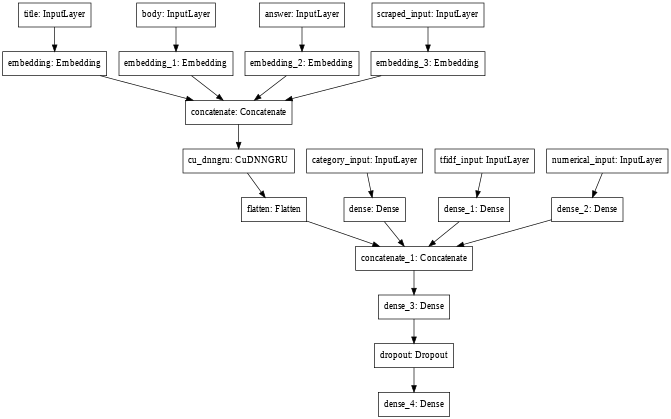

In [50]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False,
                            show_layer_names=True, rankdir='TB', expand_nested=False, dpi=48)

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, 26)]         0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, 700)]        0                                            
__________________________________________________________________________________________________
answer (InputLayer)             [(None, 800)]        0                                            
__________________________________________________________________________________________________
scraped_input (InputLayer)      [(None, 1500)]       0                                            
______________________________________________________________________________________________

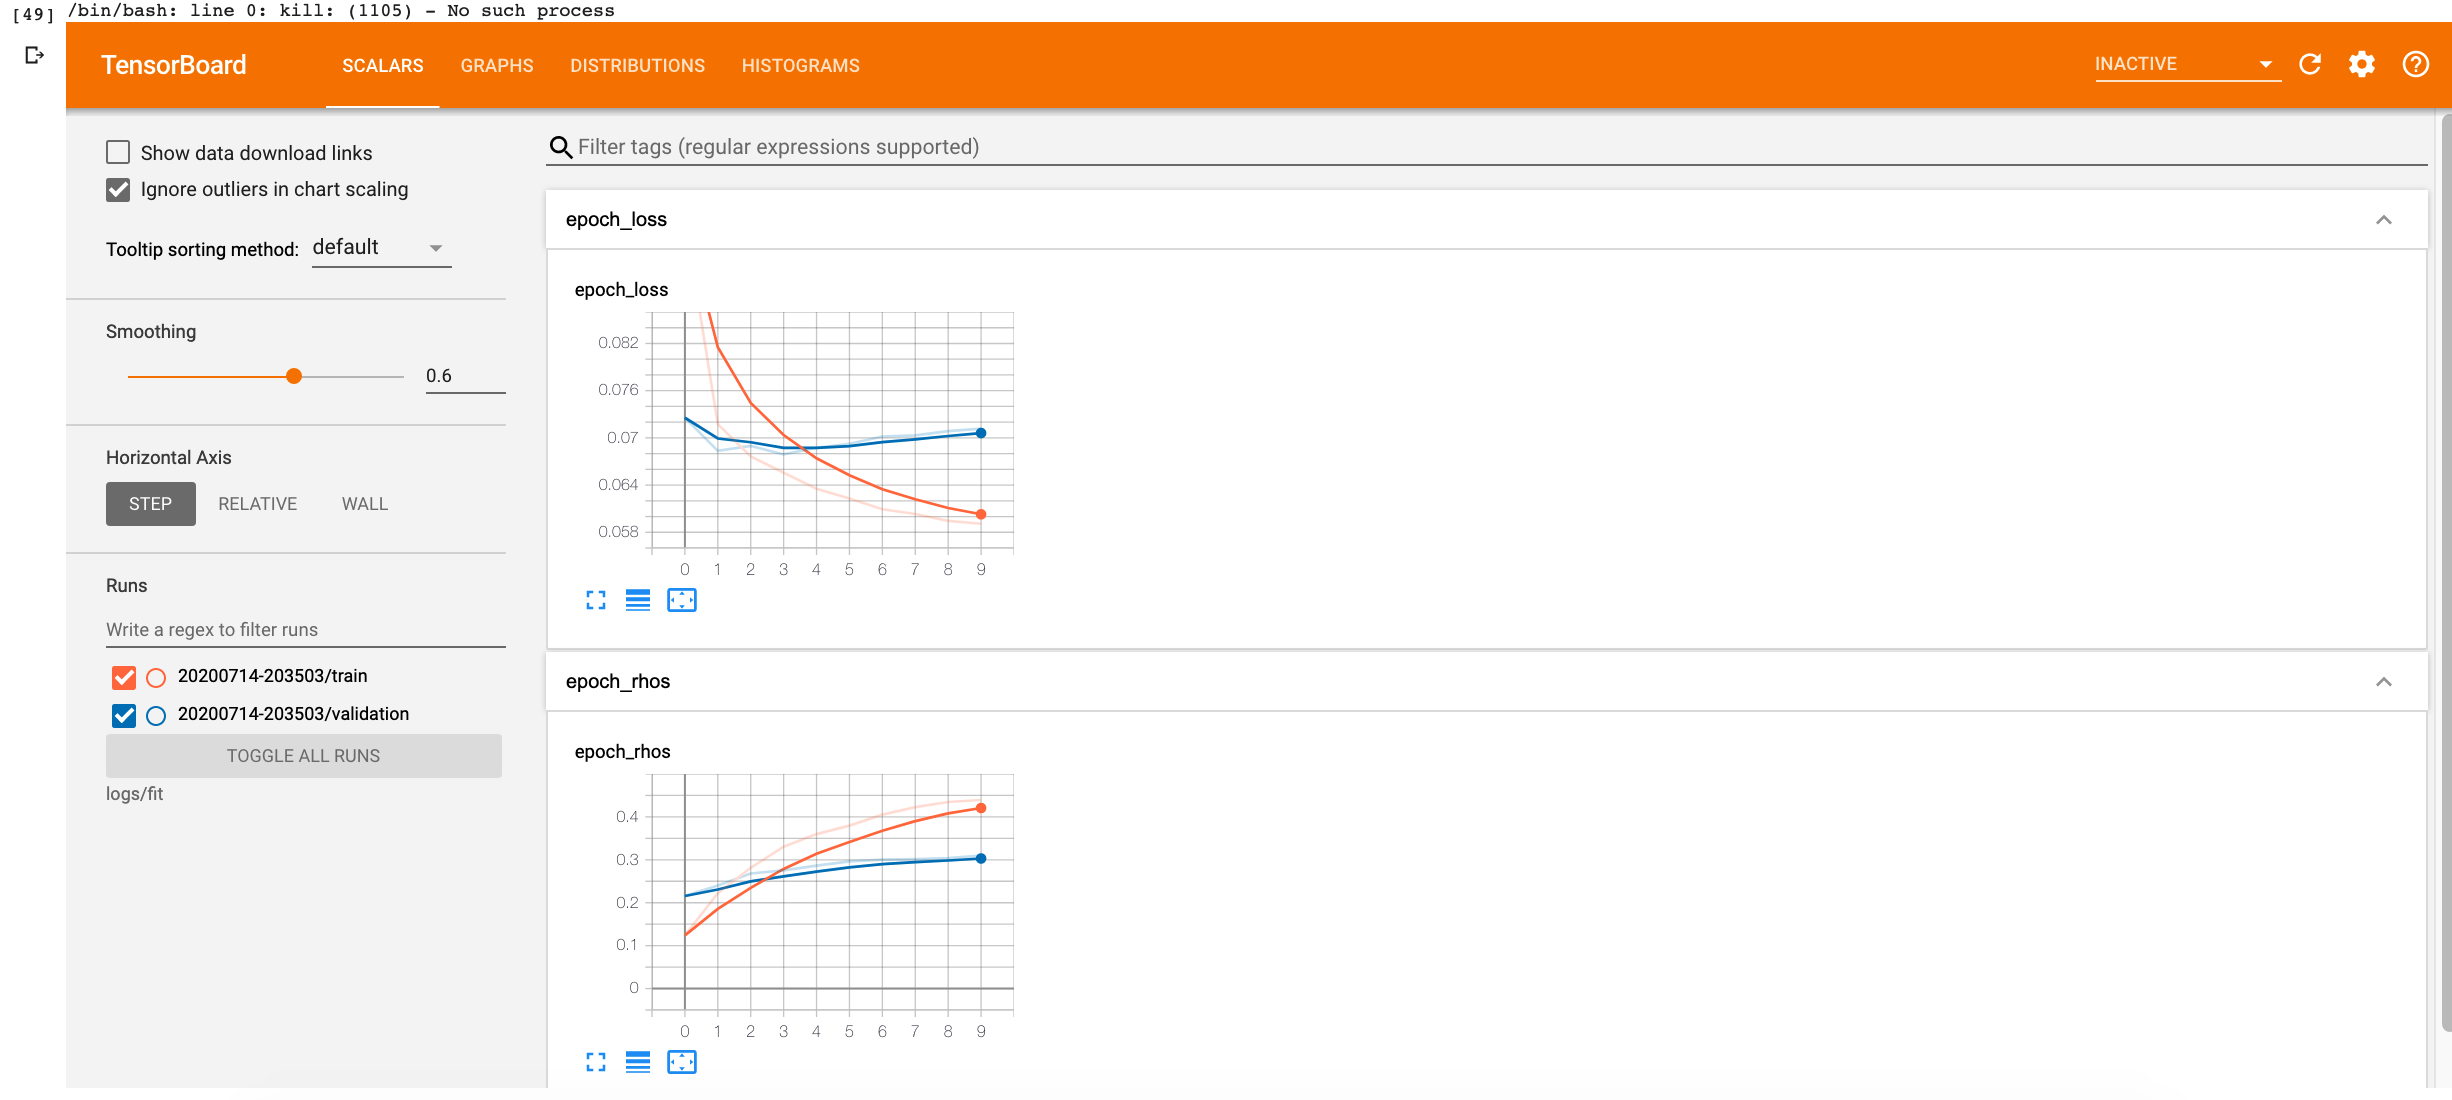

In [52]:
%matplotlib inline
from IPython.display import Image 
Image('1.png', width=920, height=480)

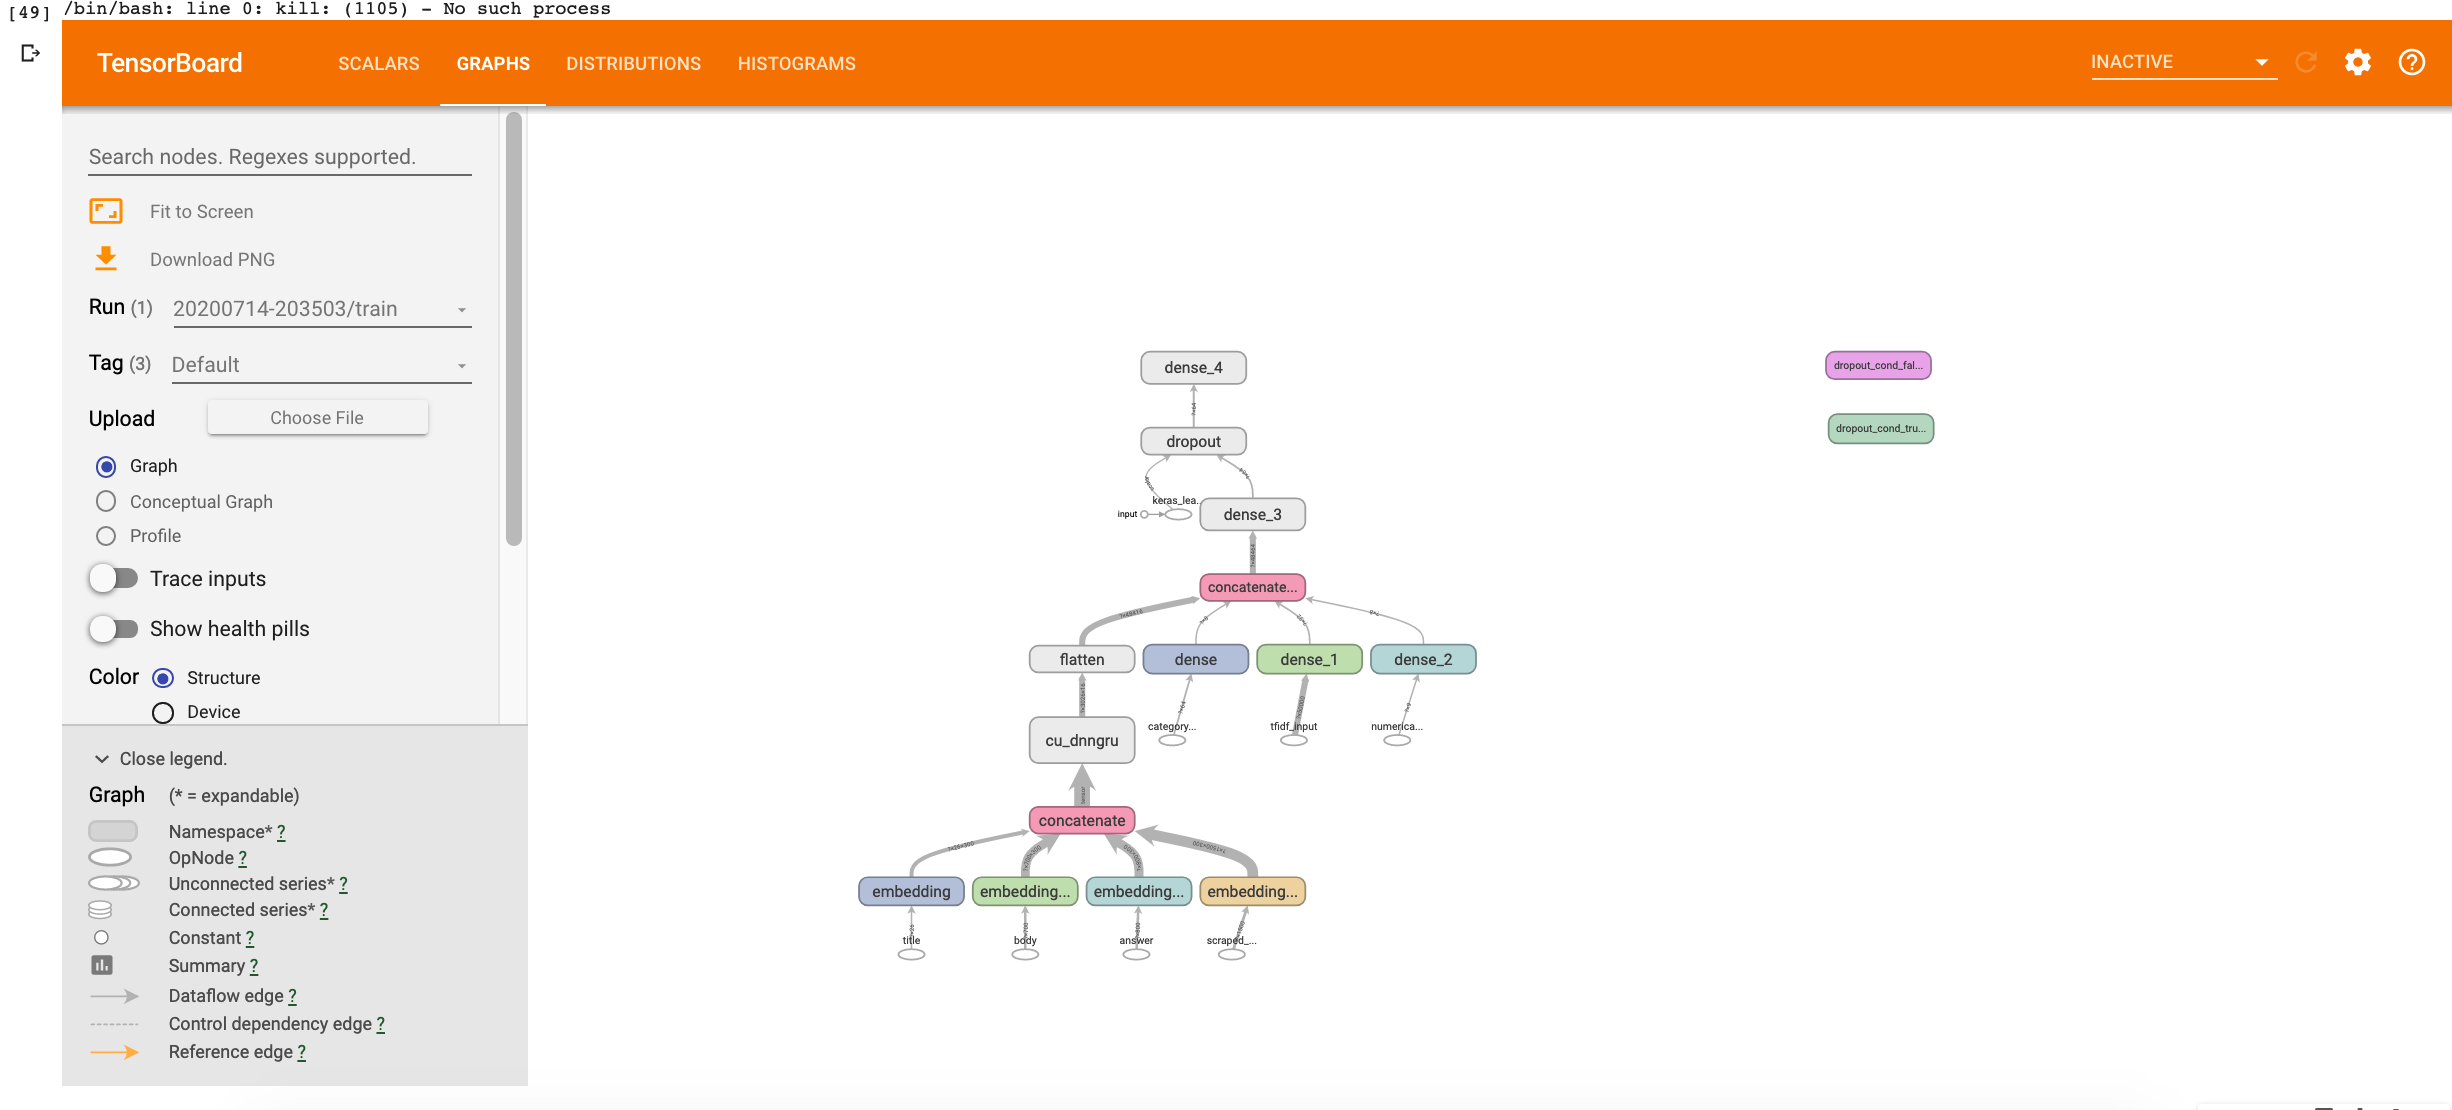

In [53]:
Image('2.png', width=920, height=480)

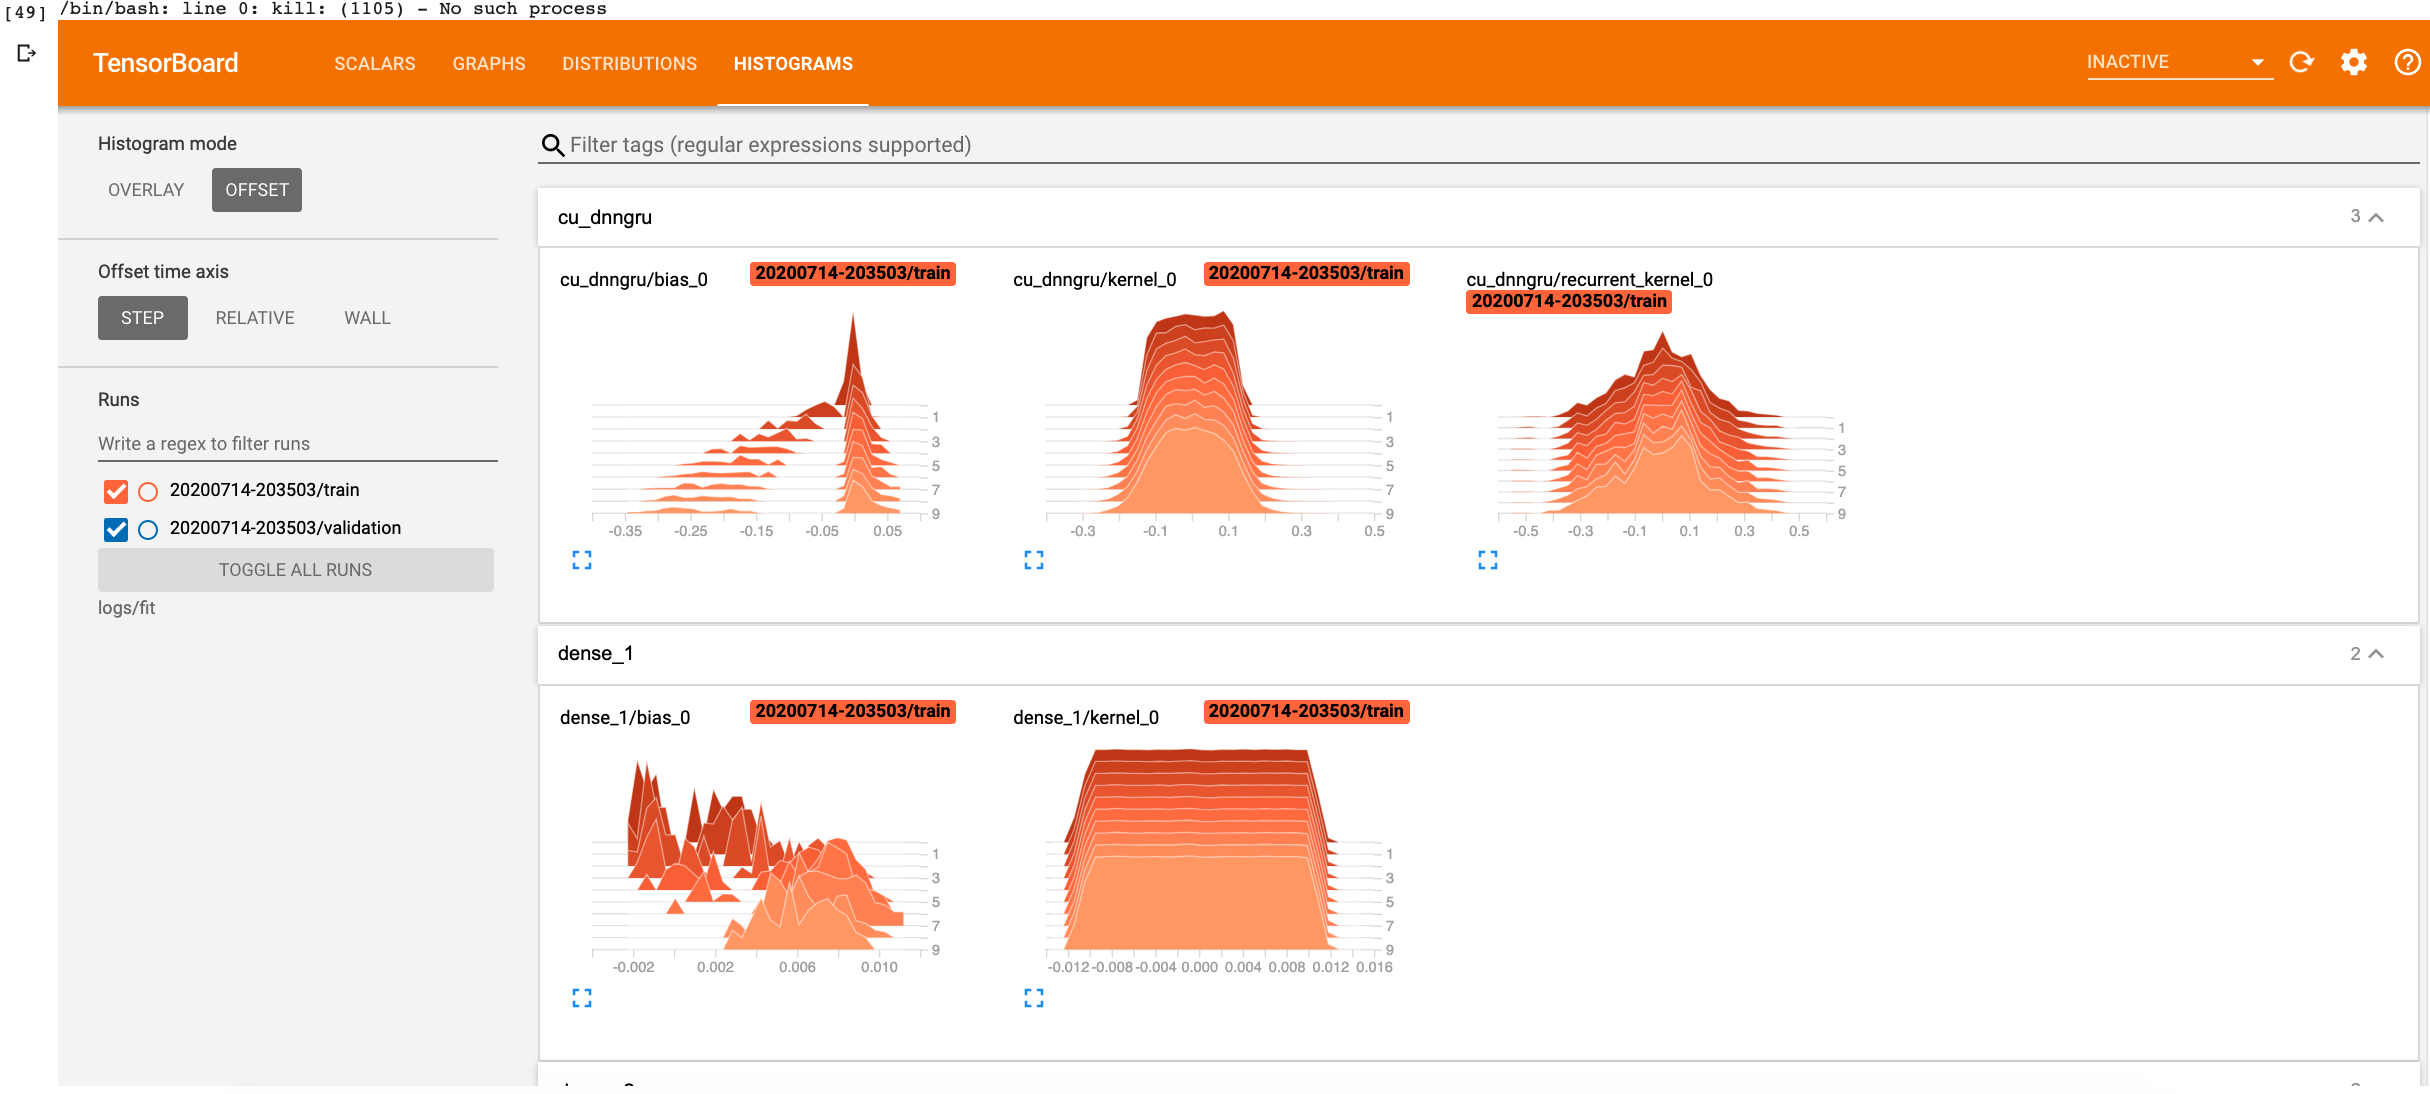

In [54]:
Image('3.png', width=920, height=480)

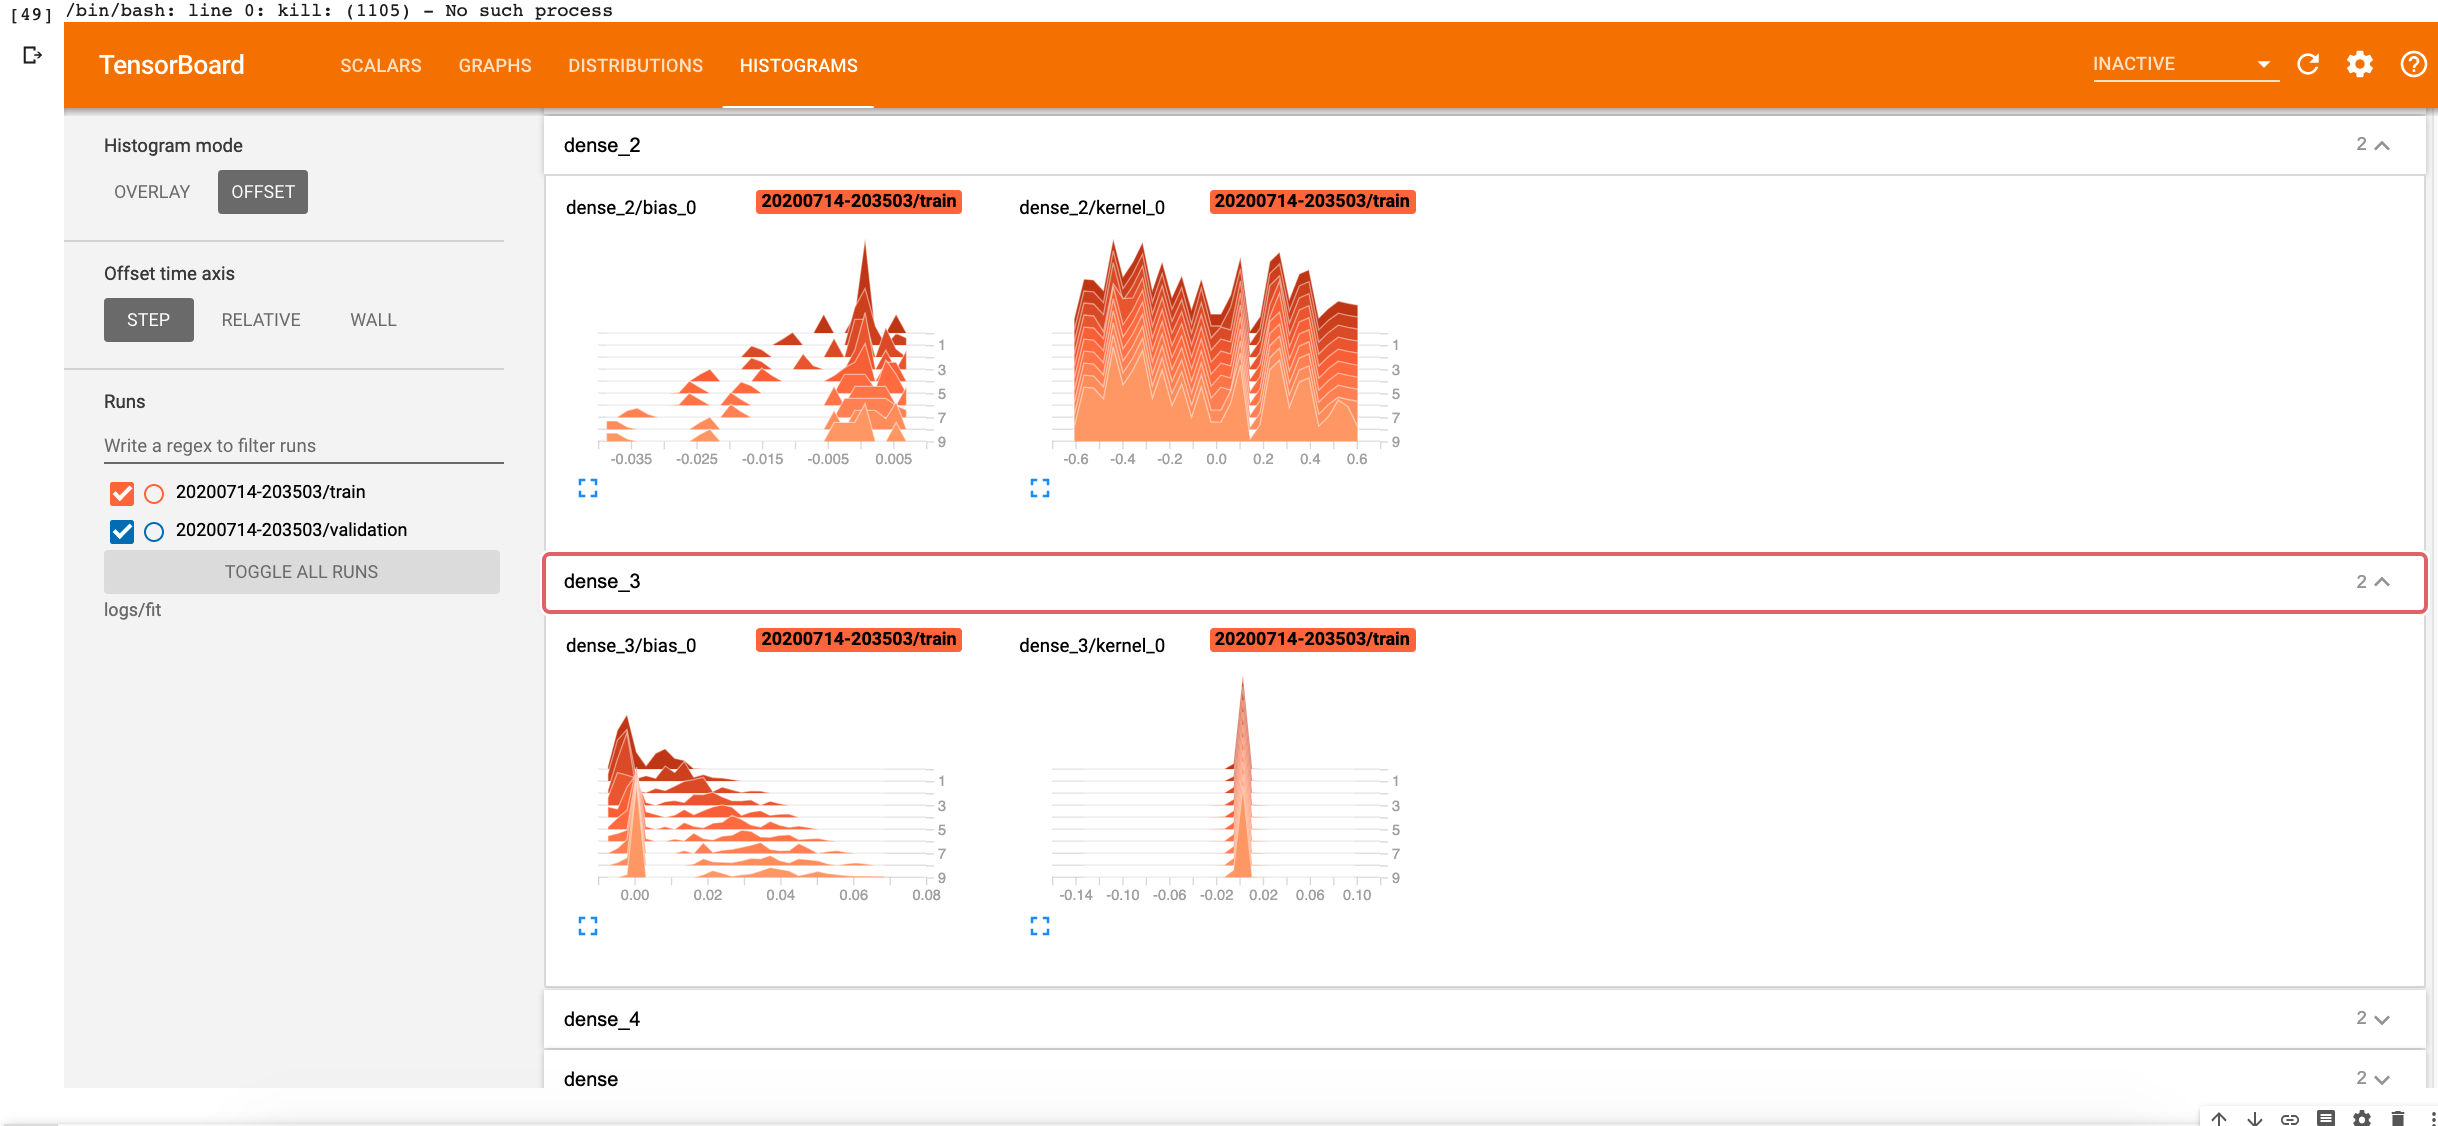

In [55]:
Image('4.png', width=920, height=480)

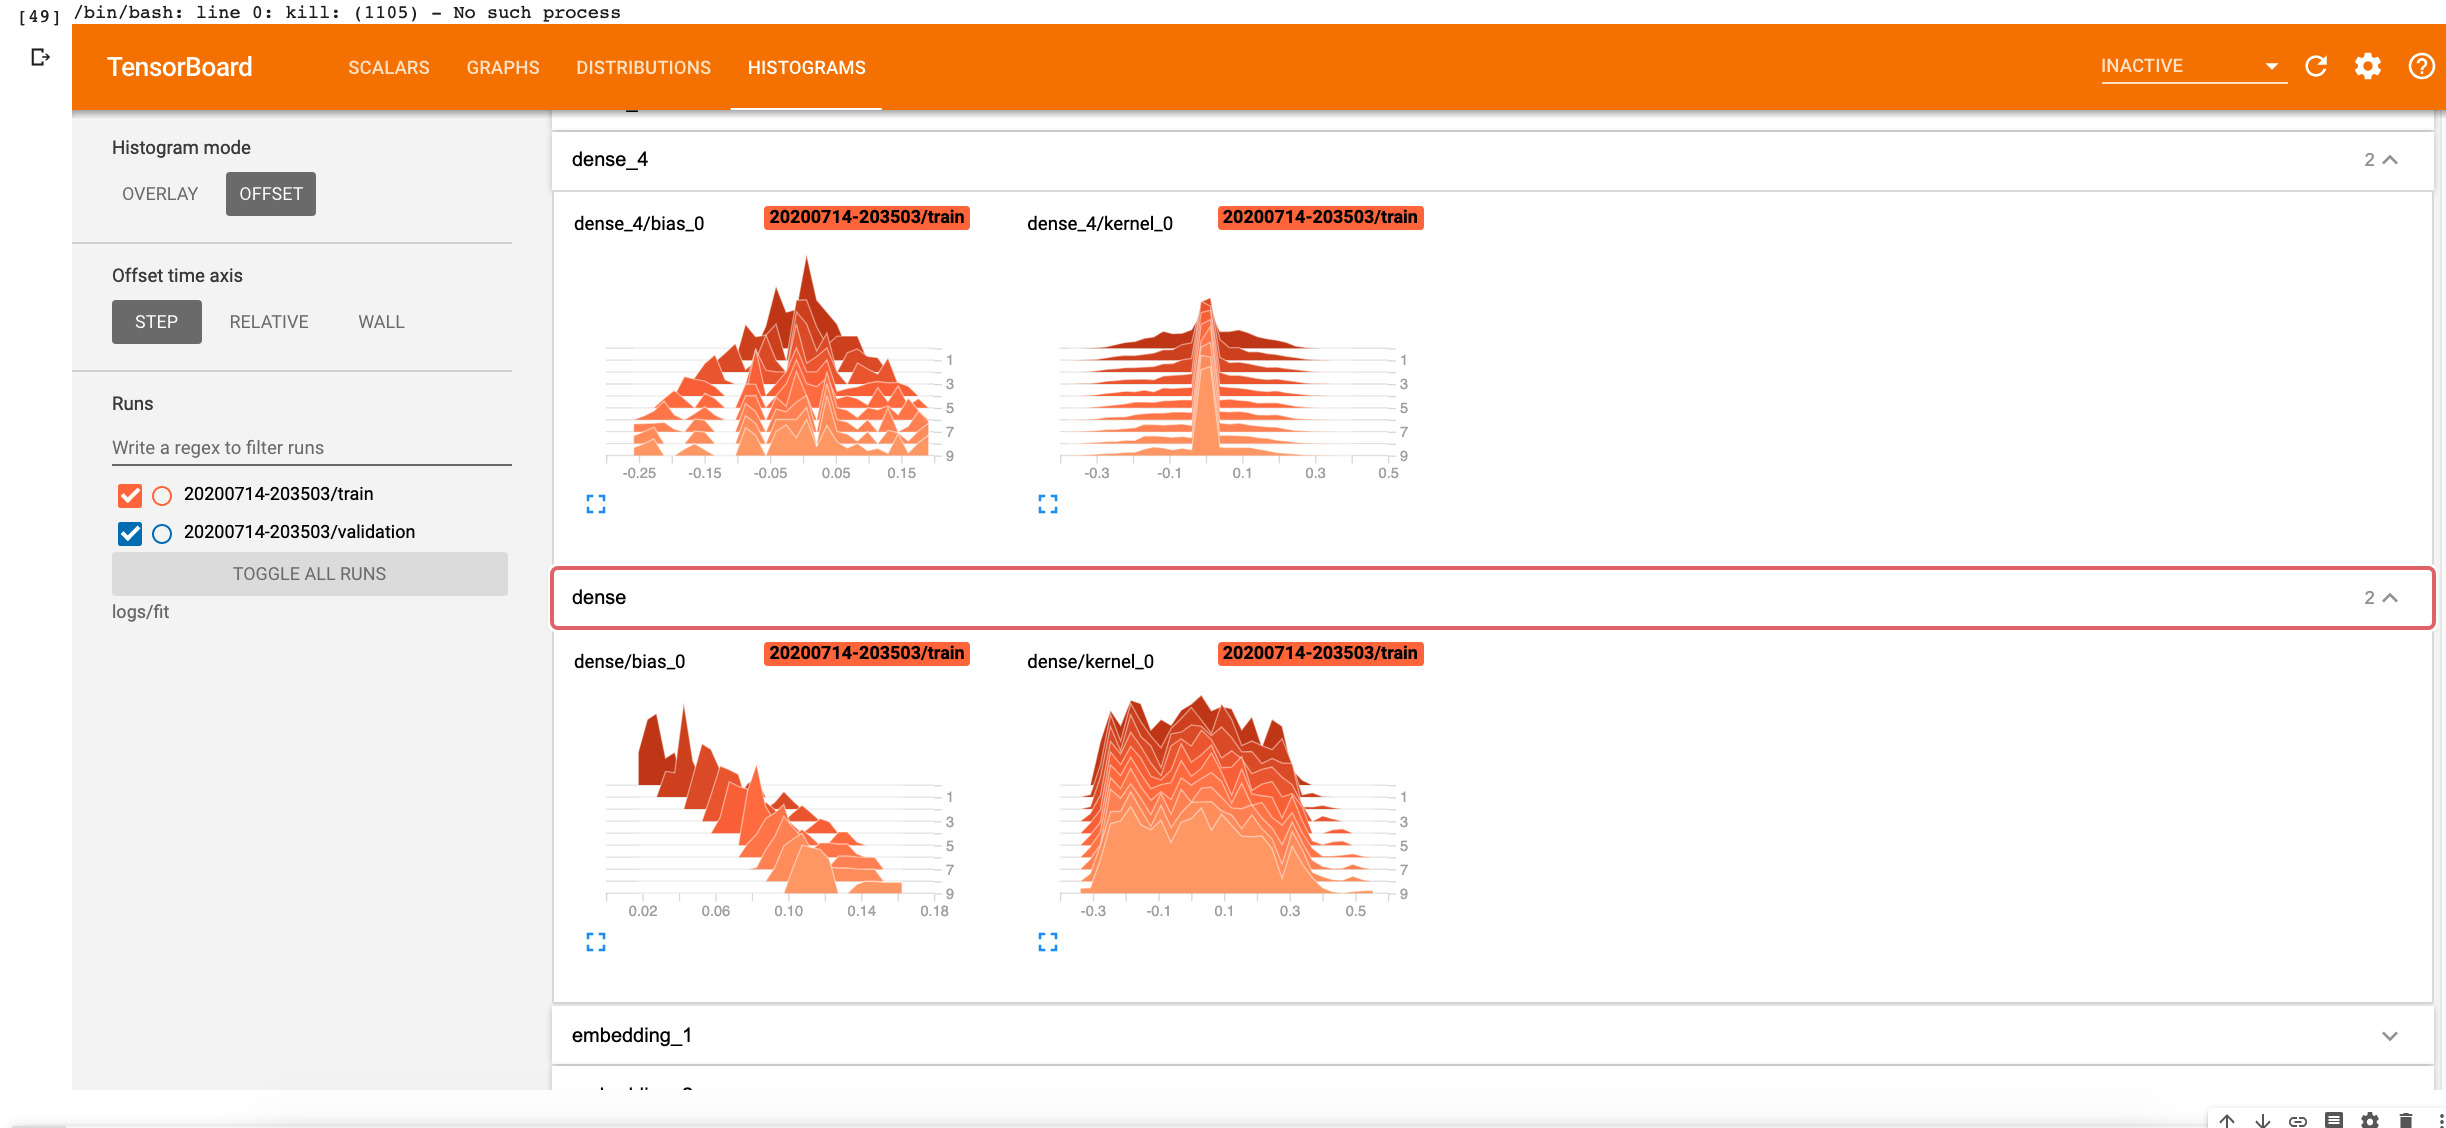

In [56]:
Image('5.png', width=920, height=480)

We can see that the bias terms of all the GRU and dense layers are getting updated, we can see the change in the histogram of gradients as the epochs increase.

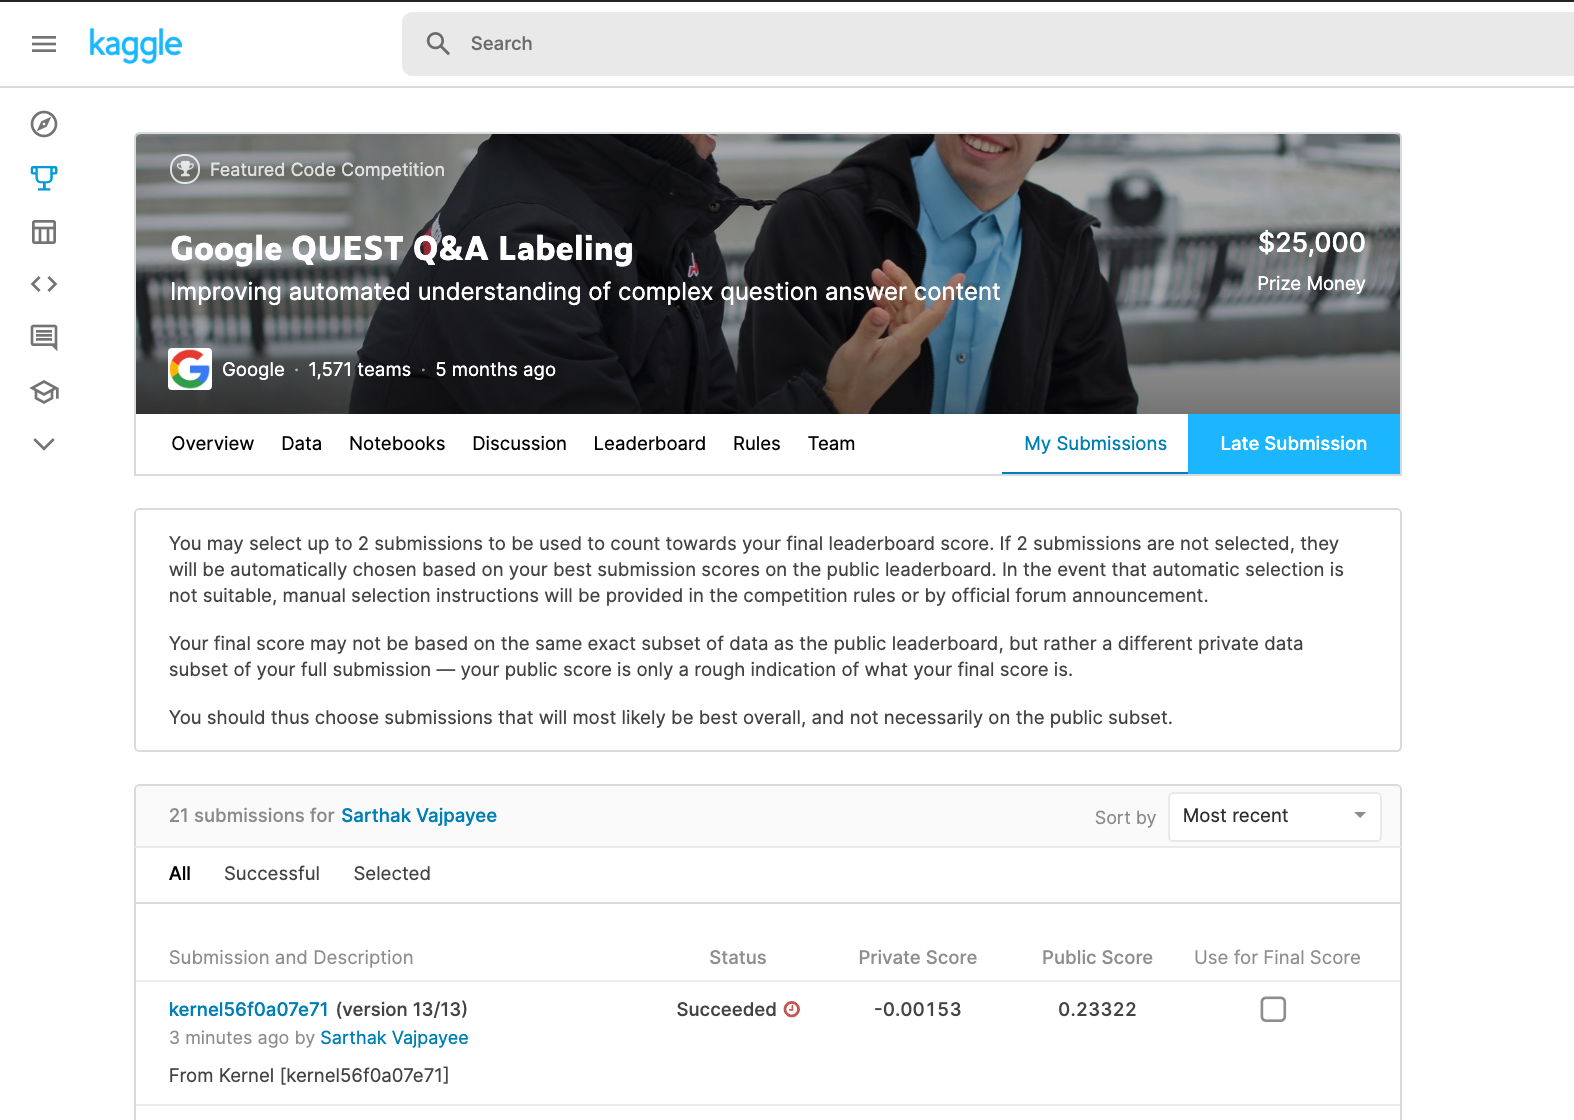

In [74]:
Image('score.png', width=630, height=480)

A score of 0.23322 was generated by kaggle on the predicted values by the baseline model.
* The score is a little bit better than the previous baseline model.

## Post-modeling analysis

In [57]:
# reading the data into dataframe using pandas
train = pd.read_csv('drive/My Drive/case_study_2/train.csv')
test = pd.read_csv('drive/My Drive/case_study_2/test.csv')
submission = pd.read_csv('drive/My Drive/case_study_2/sample_submission.csv')

In [59]:
# collecting train and cv data
X_train, X_cv, y_train, y_cv = preprocess_data(train, test, new_features_train, new_features_test, flag=1)

In [60]:
# Generating the log-losses for each data point in train and test data.
from sklearn.metrics import mean_squared_error
train_losses = [mean_squared_error(i,j) for i,j in zip(y_train_pred, y_train)]
cv_losses = [mean_squared_error(i,j) for i,j in zip(y_cv_pred, y_cv)]

In [61]:
# sorting the losses from minimum to maximum imdex wise.
train_loss_args = np.argsort(train_losses)
cv_loss_args = np.argsort(cv_losses)

#### We'll go through various analysis first starting with word cloud of the question_title, question_body and answer

In [64]:
X_train.head(3)

question_title  ... bronze_a
2313  quantity based discount for single product in ...  ...      1.0
4222  migrating a document library from sharepoint #...  ...     72.0
5346                                do not track header  ...    499.0

[3 rows x 21 columns]

In [65]:
# function for generating wordcloud
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
sns.set()

def generate_wordcloud(i, data, color='black'):
  comment_words = '' 
  stopwords = set(STOPWORDS)

  title_words = data['question_title'].iloc[i]
  body_words = data['question_body'].iloc[i]
  answer_words = data['answer'].iloc[i]

  title_cloud = WordCloud(width = 400, height = 200, background_color = color,
                        stopwords = stopwords, min_font_size = 10).generate(title_words)

  body_cloud = WordCloud(width = 400, height = 200, background_color = color,
                        stopwords = stopwords, min_font_size = 10).generate(body_words)

  answer_cloud = WordCloud(width = 400, height = 200, background_color = color,
                        stopwords = stopwords, min_font_size = 10).generate(answer_words)
  
  return title_cloud, body_cloud, answer_cloud

Top 5 data points from CV data that give the "lowest" loss.


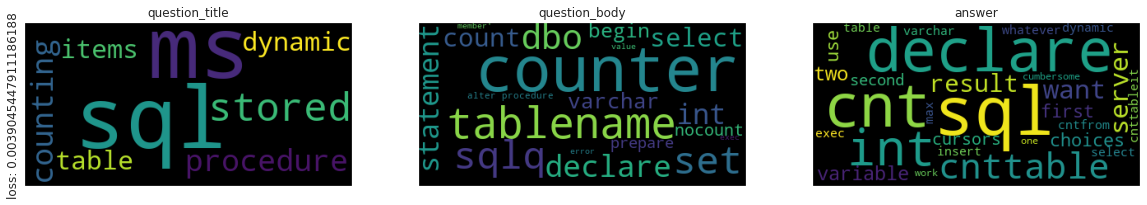

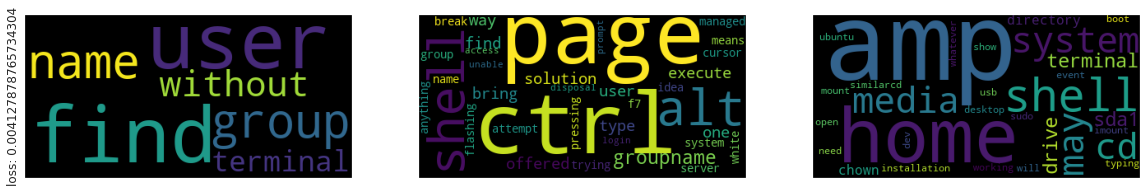

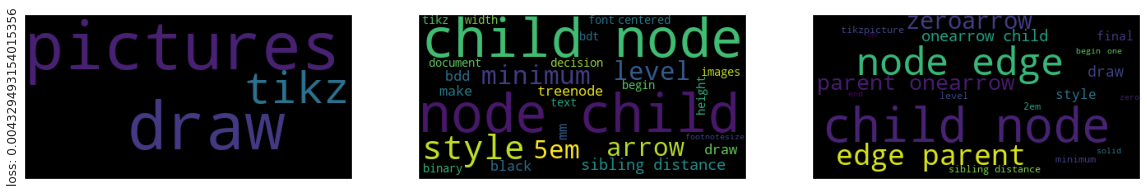

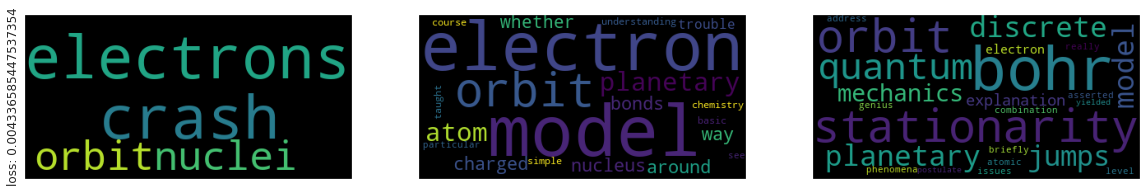

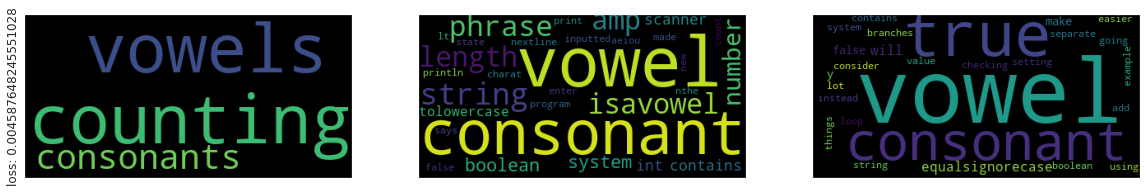

In [66]:
# I've picked the top 5 datapoints from train data with lowest loss and plotted the wordcloud of their question_title, question_body and answer.
print('Top 5 data points from CV data that give the "lowest" loss.')
for i, idx in enumerate(train_loss_args[:5]):
  title, body, answer = generate_wordcloud(idx, X_train)
  plt.figure(figsize=(20,12))
  plt.subplot(131)
  plt.imshow(title)
  if i==0: plt.title('question_title')
  plt.ylabel(f'loss: {train_losses[idx]}')
  plt.subplot(132)
  plt.imshow(body)
  if i==0: plt.title('question_body')
  plt.subplot(133)
  plt.imshow(answer)
  if i==0: plt.title('answer')
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
  plt.show()

Top 3 data points from CV data that give the "lowest" loss.


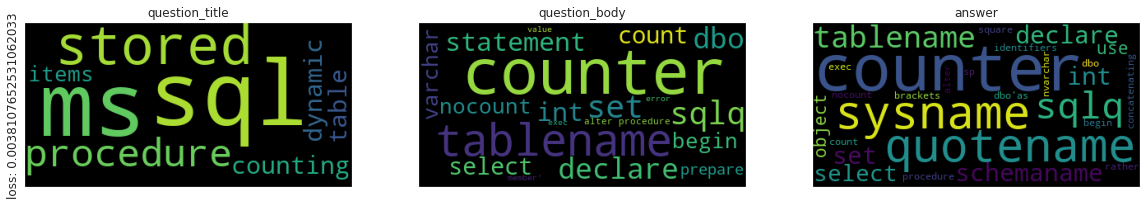

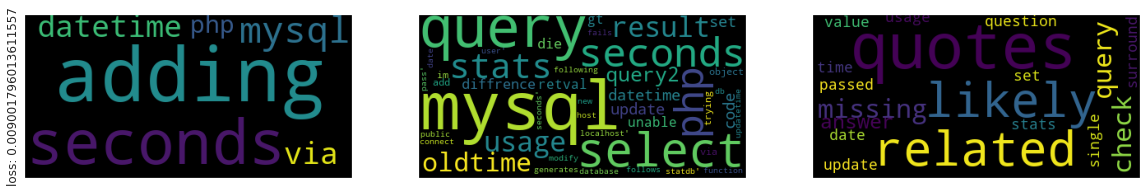

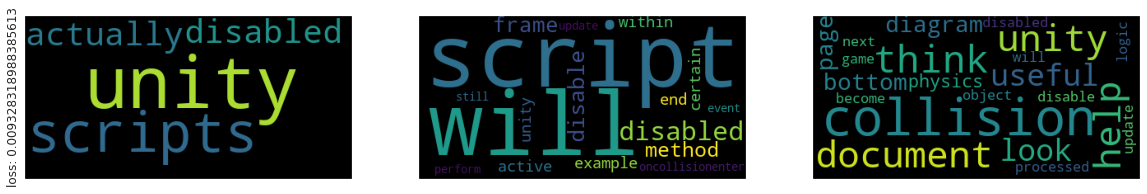

In [67]:
# I've picked the top 3 datapoints from cv data with lowest loss and plotted the wordcloud of their question_title, question_body and answer.
print('Top 3 data points from CV data that give the "lowest" loss.')
for i, idx in enumerate(cv_loss_args[:3]):
  title, body, answer = generate_wordcloud(idx, X_cv)
  plt.figure(figsize=(20,12))
  plt.subplot(131)
  plt.imshow(title)
  if i==0: plt.title('question_title')
  plt.ylabel(f'loss: {cv_losses[idx]}')
  plt.subplot(132)
  plt.imshow(body)
  if i==0: plt.title('question_body')
  plt.subplot(133)
  plt.imshow(answer)
  if i==0: plt.title('answer')
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
  plt.show()

Top 5 data points from Train data that give the "highest" loss.


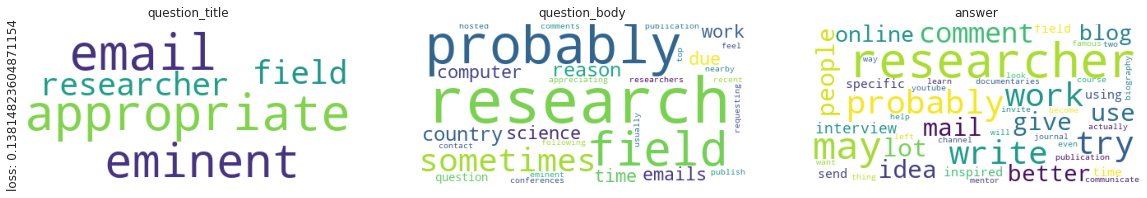

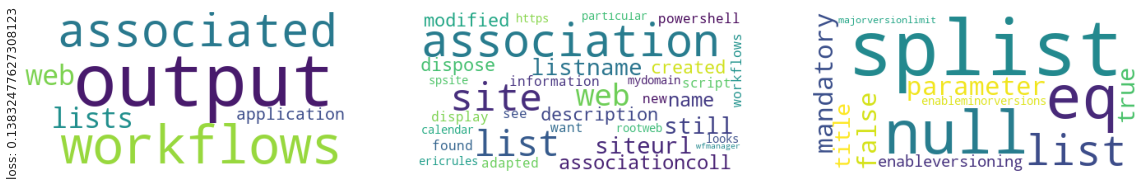

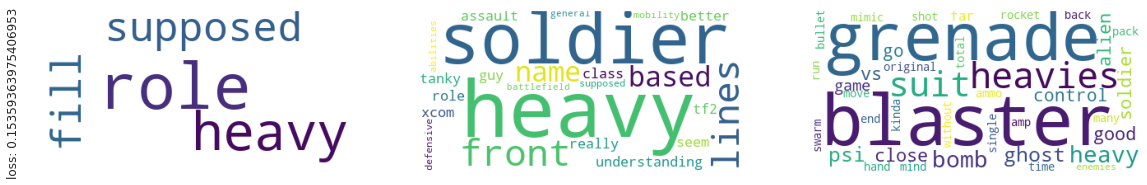

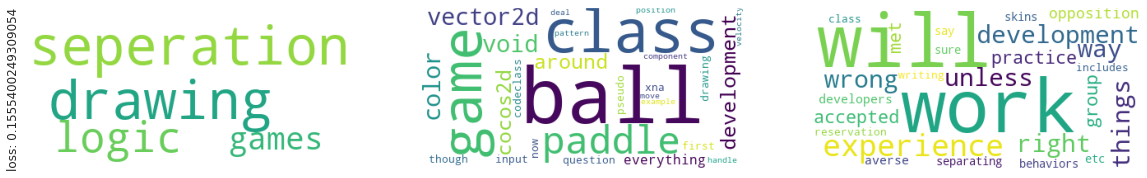

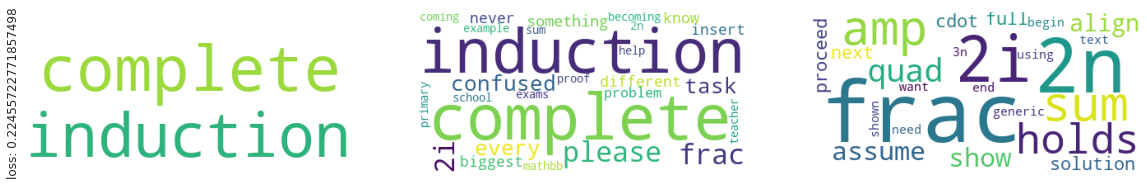

In [68]:
# I've picked the top 5 datapoints from train data with 'highest' loss and plotted the wordcloud of their question_title, question_body and answer.
print('Top 5 data points from Train data that give the "highest" loss.')
for i, idx in enumerate(train_loss_args[-5:]):
  title, body, answer = generate_wordcloud(idx, X_train, color='white')
  plt.figure(figsize=(20,12))
  plt.subplot(131)
  plt.imshow(title)
  if i==0: plt.title('question_title')
  plt.ylabel(f'loss: {train_losses[idx]}')
  plt.subplot(132)
  plt.imshow(body)
  if i==0: plt.title('question_body')
  plt.subplot(133)
  plt.imshow(answer)
  if i==0: plt.title('answer')
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
  plt.show()

Top 3 data points from CV data that give the "highest" loss.


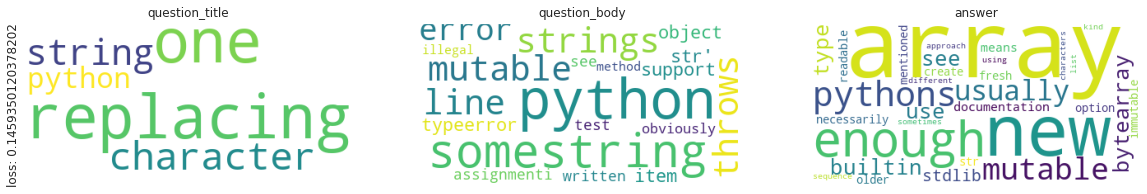

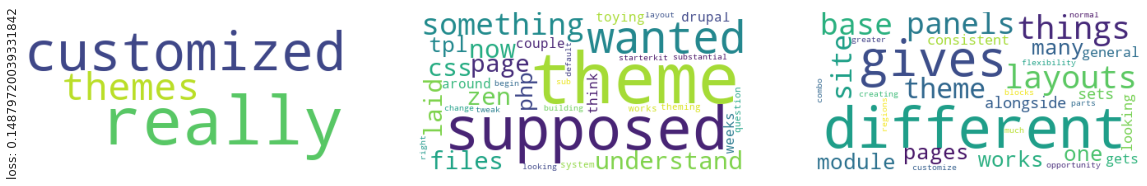

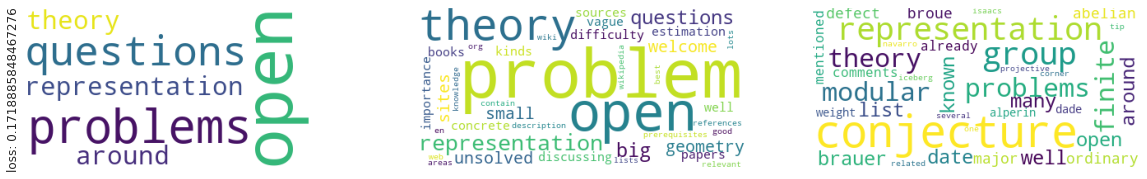

In [69]:
# I've picked the top 3 datapoints from train data with 'highest' loss and plotted the wordcloud of their question_title, question_body and answer.
print('Top 3 data points from CV data that give the "highest" loss.')
for i, idx in enumerate(cv_loss_args[-3:]):
  title, body, answer = generate_wordcloud(idx, X_cv, color='white')
  plt.figure(figsize=(20,12))
  plt.subplot(131)
  plt.imshow(title)
  if i==0: plt.title('question_title')
  plt.ylabel(f'loss: {cv_losses[idx]}')
  plt.subplot(132)
  plt.imshow(body)
  if i==0: plt.title('question_body')
  plt.subplot(133)
  plt.imshow(answer)
  if i==0: plt.title('answer')
  plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
  plt.show()

Observation: Looking at the wordclouds I can say that the datapoints that lead to a good loss are more technical and mathematics oriented whereas the datapoints that lead to a bad loss are more hypothetical or non-technical. Also there are some technical question-answers (unix and web-design based) that contribute to both good and bad losses.

#### Next analysis is on the word counts in question_title, question_body and answer.

word counts of the question_title, question_body and answer of top 30 train and cv data with 'lowest' loss.


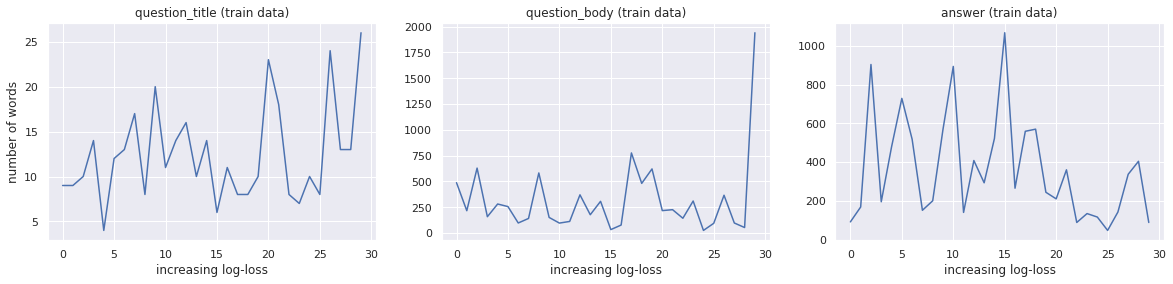

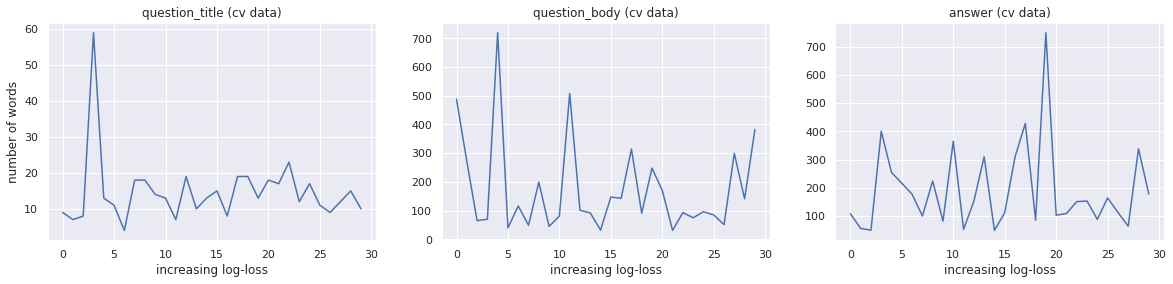

In [70]:
# I've picked the top 30 datapoints from train and cv data with 'lowest' loss and plotted the word counts of their question_title, question_body and answer.
print("word counts of the question_title, question_body and answer of top 30 train and cv data with 'lowest' loss.")
i = 30
title_train_len = [len(l.split(' ')) for l in X_train.iloc[train_loss_args[:i]]['question_title'].values]
body_train_len = [len(l.split(' ')) for l in X_train.iloc[train_loss_args[:i]]['question_body'].values]
answer_train_len = [len(l.split(' ')) for l in X_train.iloc[train_loss_args[:i]]['answer'].values]

title_cv_len = [len(l.split(' ')) for l in X_cv.iloc[cv_loss_args[:i]]['question_title'].values]
body_cv_len = [len(l.split(' ')) for l in X_cv.iloc[cv_loss_args[:i]]['question_body'].values]
answer_cv_len = [len(l.split(' ')) for l in X_cv.iloc[cv_loss_args[:i]]['answer'].values]

plt.figure(figsize=(20,4))
plt.subplot(131)
plt.plot(title_train_len)
plt.title('question_title (train data)')
plt.ylabel('number of words')
plt.xlabel('increasing log-loss')
plt.subplot(132)
plt.plot(body_train_len)
plt.title('question_body (train data)')
plt.xlabel('increasing log-loss')
plt.subplot(133)
plt.plot(answer_train_len)
plt.title('answer (train data)')
plt.xlabel('increasing log-loss')
# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

plt.figure(figsize=(20,4))
plt.subplot(131)
plt.plot(title_cv_len)
plt.title('question_title (cv data)')
plt.ylabel('number of words')
plt.xlabel('increasing log-loss')
plt.subplot(132)
plt.plot(body_cv_len)
plt.title('question_body (cv data)')
plt.xlabel('increasing log-loss')
plt.subplot(133)
plt.plot(answer_cv_len)
plt.title('answer (cv data)')
plt.xlabel('increasing log-loss')
# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

word counts of the question_title, question_body and answer of top 30 train and cv data with 'highest' loss.


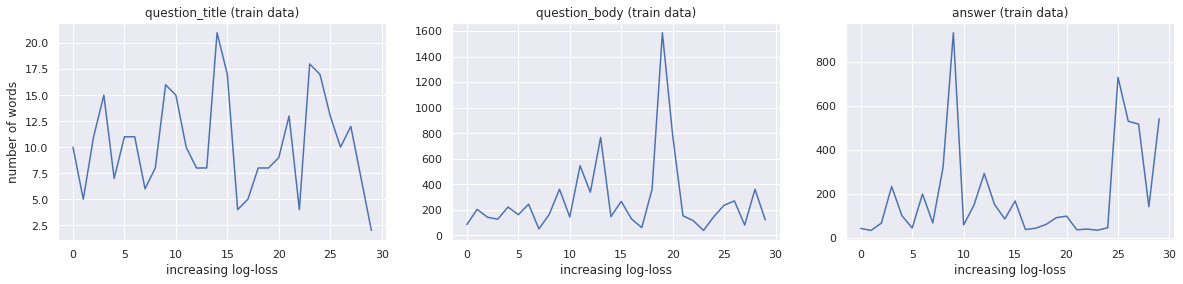

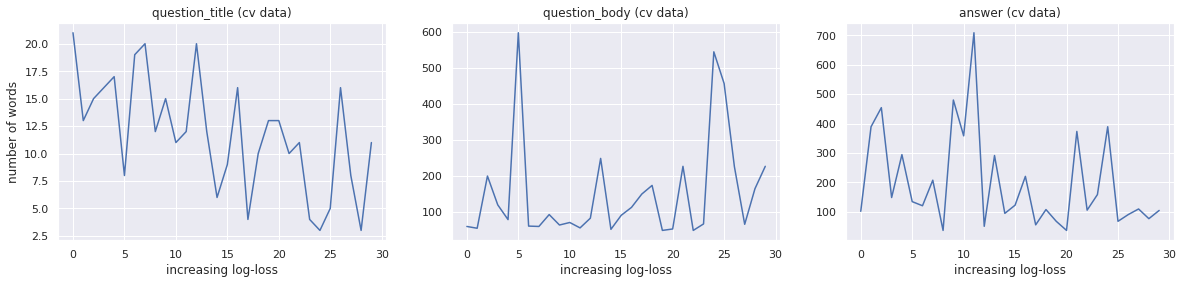

In [71]:
# I've picked the top 30 datapoints from train and cv data with 'highest' loss and plotted the word counts of their question_title, question_body and answer.
print("word counts of the question_title, question_body and answer of top 30 train and cv data with 'highest' loss.")
i = -30
title_train_len = [len(l.split(' ')) for l in X_train.iloc[train_loss_args[i:]]['question_title'].values]
body_train_len = [len(l.split(' ')) for l in X_train.iloc[train_loss_args[i:]]['question_body'].values]
answer_train_len = [len(l.split(' ')) for l in X_train.iloc[train_loss_args[i:]]['answer'].values]

title_cv_len = [len(l.split(' ')) for l in X_cv.iloc[cv_loss_args[i:]]['question_title'].values]
body_cv_len = [len(l.split(' ')) for l in X_cv.iloc[cv_loss_args[i:]]['question_body'].values]
answer_cv_len = [len(l.split(' ')) for l in X_cv.iloc[cv_loss_args[i:]]['answer'].values]

plt.figure(figsize=(20,4))
plt.subplot(131)
plt.plot(title_train_len)
plt.title('question_title (train data)')
plt.ylabel('number of words')
plt.xlabel('increasing log-loss')
plt.subplot(132)
plt.plot(body_train_len)
plt.title('question_body (train data)')
plt.xlabel('increasing log-loss')
plt.subplot(133)
plt.plot(answer_train_len)
plt.title('answer (train data)')
plt.xlabel('increasing log-loss')
# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

plt.figure(figsize=(20,4))
plt.subplot(131)
plt.plot(title_cv_len)
plt.title('question_title (cv data)')
plt.ylabel('number of words')
plt.xlabel('increasing log-loss')
plt.subplot(132)
plt.plot(body_cv_len)
plt.title('question_body (cv data)')
plt.xlabel('increasing log-loss')
plt.subplot(133)
plt.plot(answer_cv_len)
plt.title('answer (cv data)')
plt.xlabel('increasing log-loss')
# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

Observations: If we look at the number of words in question_title, question_body and answer we can observe that the data that generates a low loss has high number of words which means that the questions and answers are kind of thorough. So, the model does a good job when the questions and answers are detailed.

#### The next analysis is on the frequency of  url domain names that lead to good or bad losses.

In [72]:
# I've picked the top 100 datapoints from train data with 'highest' loss and collected the values of domain names.
top_url = X_train['clean_url'].iloc[train_loss_args[:100]].value_counts()
bottom_url = X_train['clean_url'].iloc[train_loss_args[-100:]].value_counts()

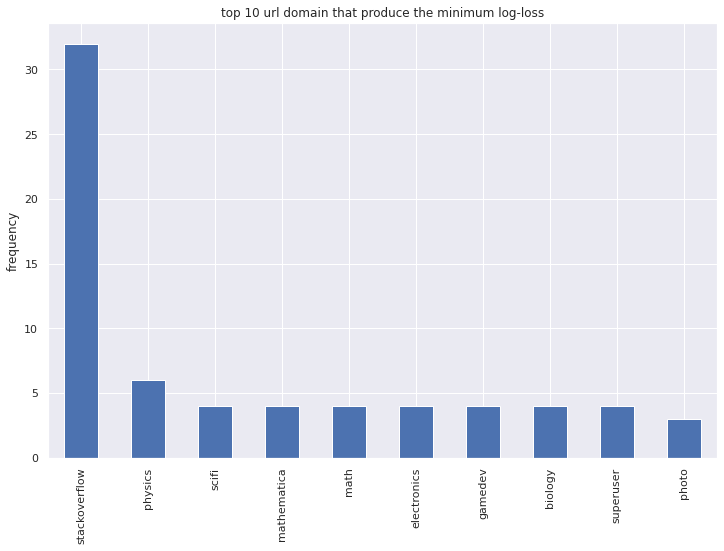

In [73]:
# Top 10 frequently occuring domain names that lead to minimum loss
top_url[:10].plot.bar(figsize=(12,8))
plt.title('top 10 url domain that produce the minimum log-loss')
plt.ylabel('frequency')
plt.show()

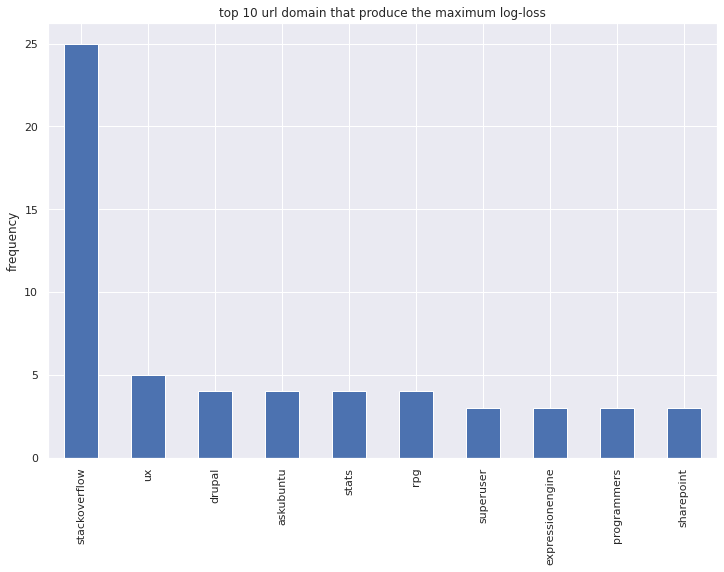

In [75]:
# Top 10 frequently occuring domain names that lead to maximum loss
bottom_url[:10].plot.bar(figsize=(12,8))
plt.title('top 10 url domain that produce the maximum log-loss')
plt.ylabel('frequency')
plt.show()

Observations: We can see that there are a lot of datapoints from domain stackoverflow, physics, sci-fi that contribute to a lesser loss value whereas there are a lot of datapoints from (again) stackoverflow and ux that contribute to a higher loss.

#### The next analysis is about which domain names contribute to minimum and maximum losses

In [76]:
# finding the unique domain names that contribute to low and high losses
best_url = ' '.join(list(set(top_url.keys()) - set(bottom_url.keys()))) # set of urls that contribute solely to low loss
worst_url = ' '.join(list(set(bottom_url.keys()) - set(top_url.keys()))) # set of urls that contribute solely to high loss

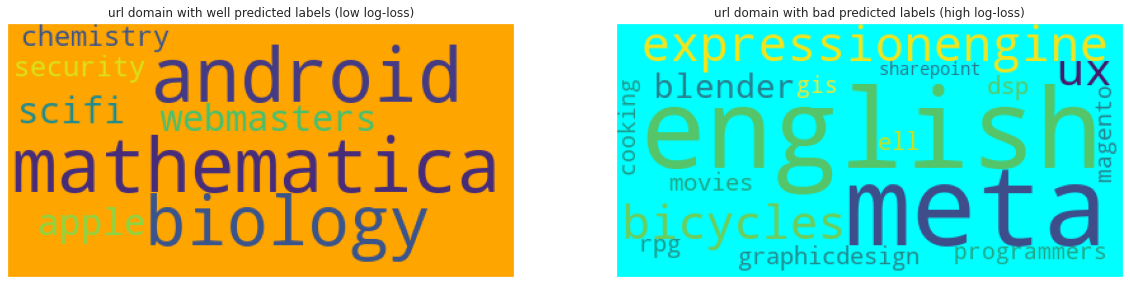

In [77]:
best_url_cloud = WordCloud(width = 400, height = 200, background_color ='orange',
                           stopwords = STOPWORDS, min_font_size = 10).generate(best_url)

worst_url_cloud = WordCloud(width = 400, height = 200, background_color ='cyan',
                            stopwords = STOPWORDS, min_font_size = 10).generate(worst_url)

plt.figure(figsize=(20,12))
plt.subplot(121)
plt.imshow(best_url_cloud)
plt.title('url domain with well predicted labels (low log-loss)')
plt.subplot(122)
plt.imshow(worst_url_cloud)
plt.title('url domain with bad predicted labels (high log-loss)')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

Observation: We can see that the data with science/tech like android, chemistry even scify contribute to a lower loss whereas data with non-science tags like cooking, english, movies, ux etc. contribute to a higher loss.

#### Finally let's analyze the final feature, 'category'.
#### For this I'll be plotting the piecharts of the categories of the top 100 data points that generate the lowest and highest loss.

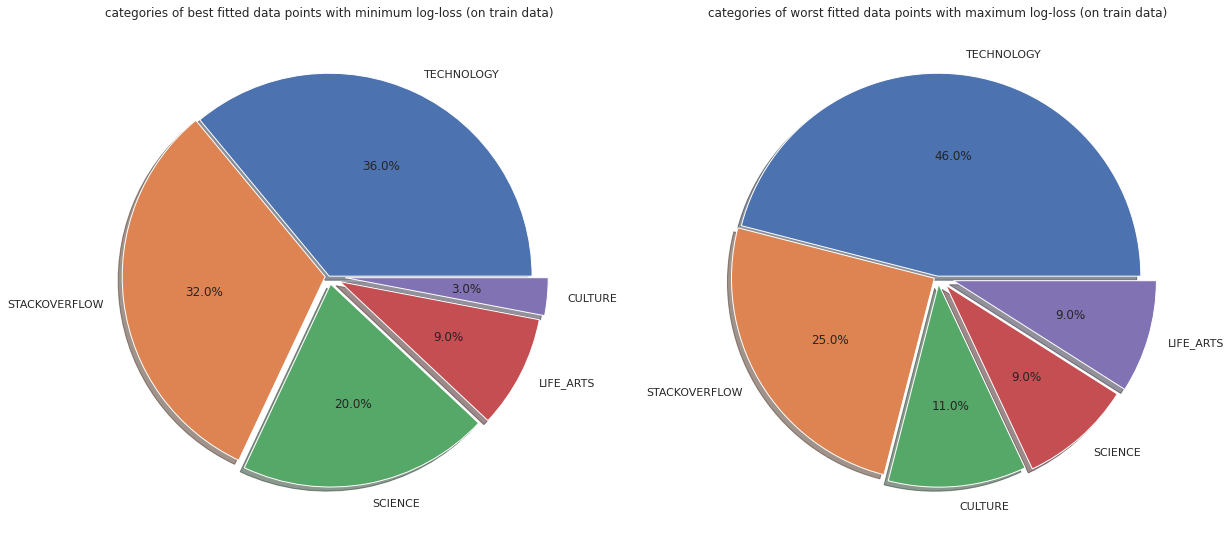

In [78]:
# for train data
plt.figure(figsize=(20,20))
plt.subplot(121)
X_train['category'].iloc[train_loss_args[:100]].value_counts().plot.pie(autopct='%1.1f%%', explode=(0,0.02,0.04,0.06,0.08), shadow=True)
plt.ylabel('')
plt.title('categories of best fitted data points with minimum log-loss (on train data)')
plt.subplot(122)
X_train['category'].iloc[train_loss_args[-100:]].value_counts().plot.pie(autopct='%1.1f%%', explode=(0,0.02,0.04,0.06,0.08), shadow=True)
plt.ylabel('')
plt.title('categories of worst fitted data points with maximum log-loss (on train data)')
plt.show()

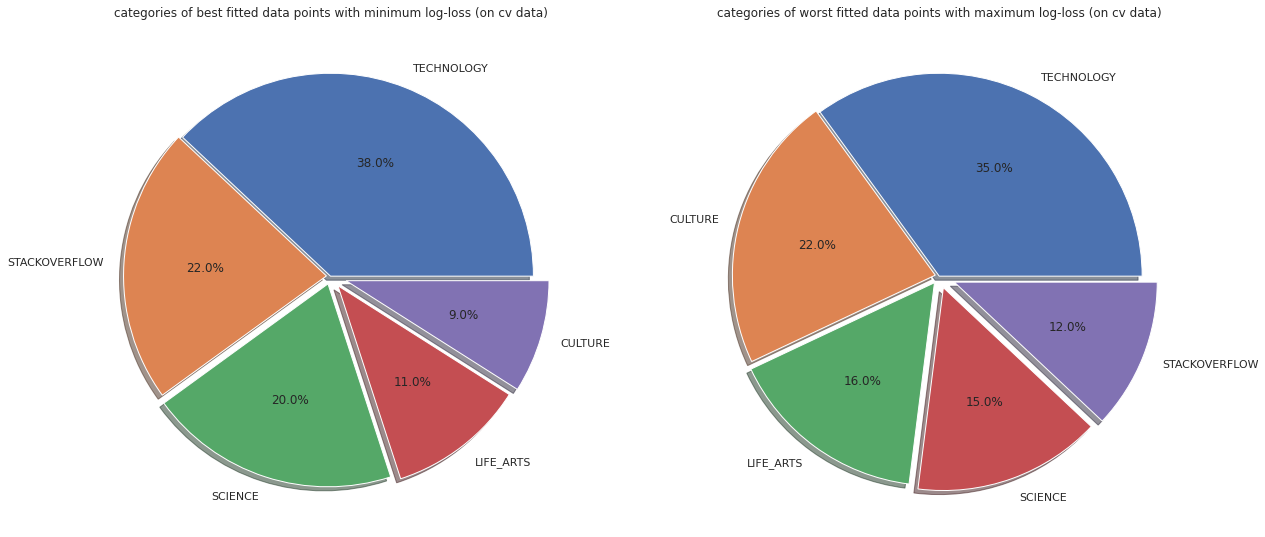

In [79]:
# for test data
plt.figure(figsize=(20,20))
plt.subplot(121)
X_cv['category'].iloc[cv_loss_args[:100]].value_counts().plot.pie(autopct='%1.1f%%', explode=(0,0.02,0.04,0.06,0.08), shadow=True)
plt.ylabel('')
plt.title('categories of best fitted data points with minimum log-loss (on cv data)')
plt.subplot(122)
X_cv['category'].iloc[cv_loss_args[-100:]].value_counts().plot.pie(autopct='%1.1f%%', explode=(0,0.02,0.04,0.06,0.08), shadow=True)
plt.ylabel('')
plt.title('categories of worst fitted data points with maximum log-loss (on cv data)')
plt.show()

We can observe that in the top 100 points, points with category stackoverflow contributes the most to a low loss whereas lifearts and culture contribute more to a high loss. Technology and science almost contribute equally to both high and low losses.

#### New features

word counts of the 'comments_0', 'answer_1', 'comment_1', 'answer_2','comment_2', 'answer_3', 'comment_3' of top 30 train and cv data with 'lowest' loss.


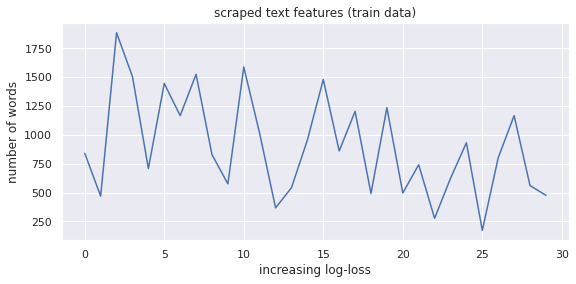

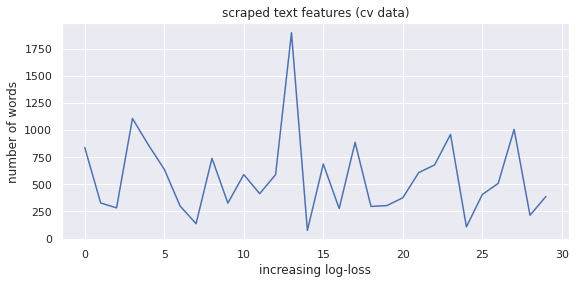

In [82]:
# I've picked the top 30 datapoints from train and cv data with 'lowest' loss and plotted the word counts of their question_title, question_body and answer.
print("word counts of the 'comments_0', 'answer_1', 'comment_1', 'answer_2','comment_2', 'answer_3', 'comment_3' of top 30 train and cv data with 'lowest' loss.")
scraped_text_features = ['comments_0', 'answer_1', 'comment_1', 'answer_2','comment_2', 'answer_3', 'comment_3']
i = 30
scraped_train_len = [len(' '.join(l).split(' ')) for l in X_train.iloc[train_loss_args[:i]][scraped_text_features].values]
scraped_cv_len = [len(' '.join(l).split(' ')) for l in X_cv.iloc[cv_loss_args[:i]][scraped_text_features].values]

plt.figure(figsize=(20,4))
plt.subplot(121)
plt.plot(scraped_train_len)
plt.title('scraped text features (train data)')
plt.ylabel('number of words')
plt.xlabel('increasing log-loss')

plt.figure(figsize=(20,4))
plt.subplot(122)
plt.plot(scraped_cv_len)
plt.title('scraped text features (cv data)')
plt.ylabel('number of words')
plt.xlabel('increasing log-loss')
plt.show()

word counts of the 'comments_0', 'answer_1', 'comment_1', 'answer_2','comment_2', 'answer_3', 'comment_3' of top 30 train and cv data with 'highest' loss.


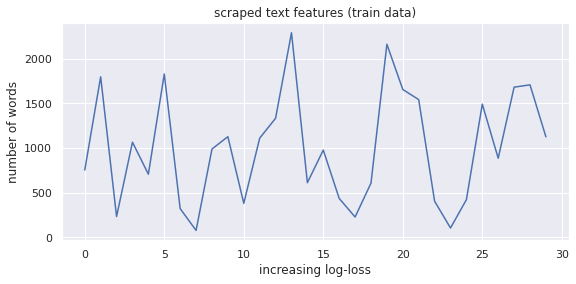

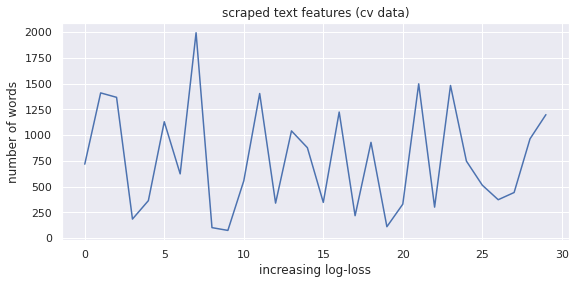

In [84]:
# I've picked the top 30 datapoints from train and cv data with 'lowest' loss and plotted the word counts of their question_title, question_body and answer.
print("word counts of the 'comments_0', 'answer_1', 'comment_1', 'answer_2','comment_2', 'answer_3', 'comment_3' of top 30 train and cv data with 'highest' loss.")
scraped_text_features = ['comments_0', 'answer_1', 'comment_1', 'answer_2','comment_2', 'answer_3', 'comment_3']
i = -30
scraped_train_len = [len(' '.join(l).split(' ')) for l in X_train.iloc[train_loss_args[i:]][scraped_text_features].values]
scraped_cv_len = [len(' '.join(l).split(' ')) for l in X_cv.iloc[cv_loss_args[i:]][scraped_text_features].values]

plt.figure(figsize=(20,4))
plt.subplot(121)
plt.plot(scraped_train_len)
plt.title('scraped text features (train data)')
plt.ylabel('number of words')
plt.xlabel('increasing log-loss')

plt.figure(figsize=(20,4))
plt.subplot(122)
plt.plot(scraped_cv_len)
plt.title('scraped text features (cv data)')
plt.ylabel('number of words')
plt.xlabel('increasing log-loss')
plt.show()

#### Upvotes

plot of the 'upvotes' of top 100 train and cv data with 'lowest' loss.


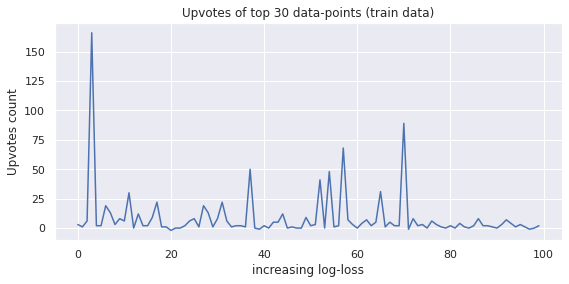

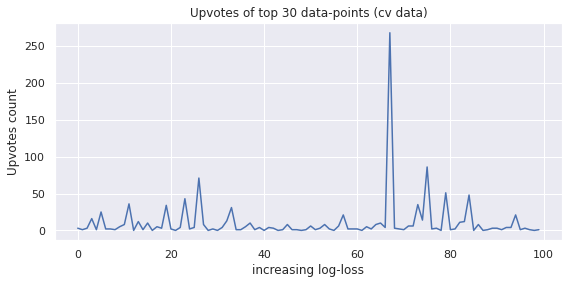

In [95]:
# I've picked the top 100 datapoints from train and cv data with 'lowest' loss and plotted the word counts of their question_title, question_body and answer.
print("plot of the 'upvotes' of top 100 train and cv data with 'lowest' loss.")
i = 100
scraped_train_len = X_train.iloc[train_loss_args[:i]]['upvotes'].values
scraped_cv_len = X_cv.iloc[cv_loss_args[:i]]['upvotes'].values

plt.figure(figsize=(20,4))
plt.subplot(121)
plt.plot(scraped_train_len)
plt.title('Upvotes of top 30 data-points (train data)')
plt.ylabel('Upvotes count')
plt.xlabel('increasing log-loss')

plt.figure(figsize=(20,4))
plt.subplot(122)
plt.plot(scraped_cv_len)
plt.title('Upvotes of top 30 data-points (cv data)')
plt.ylabel('Upvotes count')
plt.xlabel('increasing log-loss')
plt.show()

plot of the 'upvotes' of top 100 train and cv data with 'highest' loss.


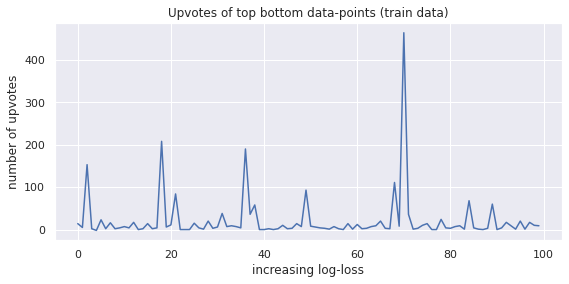

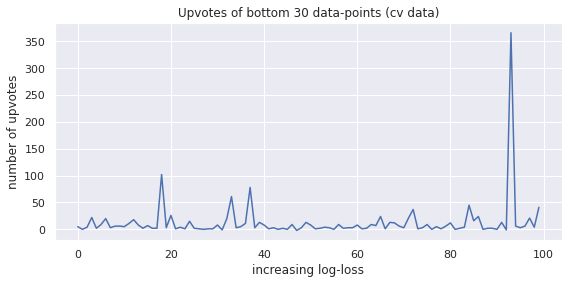

In [96]:
# I've picked the top 100 datapoints from train and cv data with 'lowest' loss and plotted the word counts of their question_title, question_body and answer.
print("plot of the 'upvotes' of top 100 train and cv data with 'highest' loss.")
i = -100
scraped_train_len = X_train.iloc[train_loss_args[i:]]['upvotes'].values
scraped_cv_len = X_cv.iloc[cv_loss_args[i:]]['upvotes'].values

plt.figure(figsize=(20,4))
plt.subplot(121)
plt.plot(scraped_train_len)
plt.title('Upvotes of top bottom data-points (train data)')
plt.ylabel('number of upvotes')
plt.xlabel('increasing log-loss')

plt.figure(figsize=(20,4))
plt.subplot(122)
plt.plot(scraped_cv_len)
plt.title('Upvotes of bottom 30 data-points (cv data)')
plt.ylabel('number of upvotes')
plt.xlabel('increasing log-loss')
plt.show()

#### We can see that the better predicted points tend to have upvotes typically between 0 and 40 whereas for the worst predicted points, the upvotes are more extreme i.e. either too low or too high.